In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import pywt as pywt

from scipy import io, ndimage
from sigtools.sigtools import *
from sigtools.differentiator import Differentiator
from scipy.signal import stft, istft, spectrogram, freqz
from sklearn.decomposition import NMF
from numpy import linalg
from statsmodels.robust import mad



Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [14]:
figPath = './figs-01-31/'
fs = 32.768e6
nfft = 19
nperseg = 19
beta_loss = 'kullback-leibler'
save_fig = False
exp_name = 'sawtooth'

In [6]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [7]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

In [8]:
def mean_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.mean(y[i:i+window_length:hop_size]))
    return np.asarray(window)

In [9]:
def median_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.median(y[i:i+window_length:hop_size]))
    return np.asarray(window)

# Bandwidth loop

/home/felipe/miniconda3/envs/python3/lib/python3.7/site-packages/pywt/_dwt.py:267: ComplexWarning: Casting complex values to real discards the imaginary part
  cA = cA.astype(np.float64)


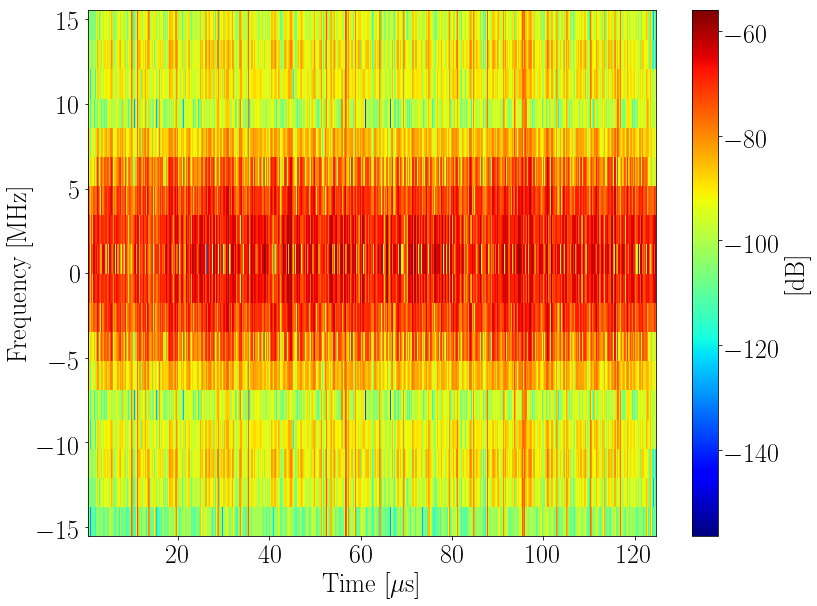

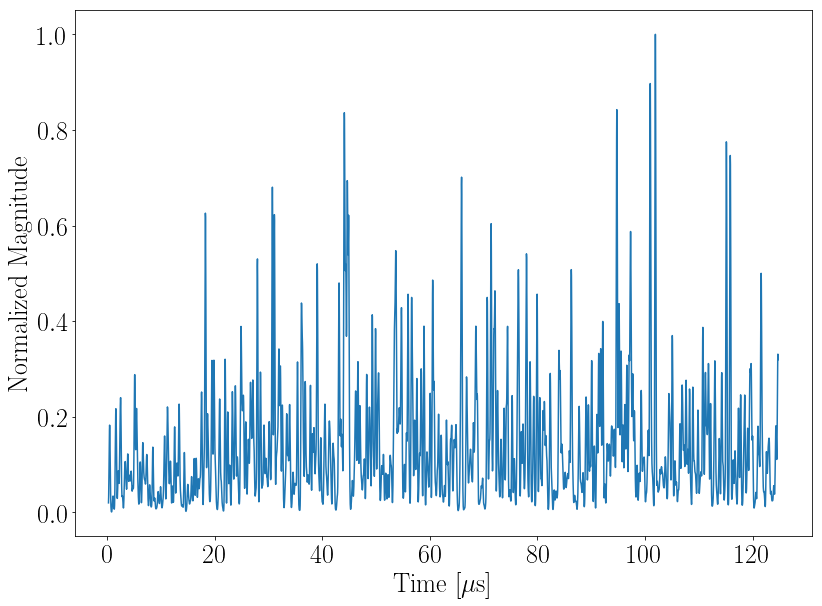

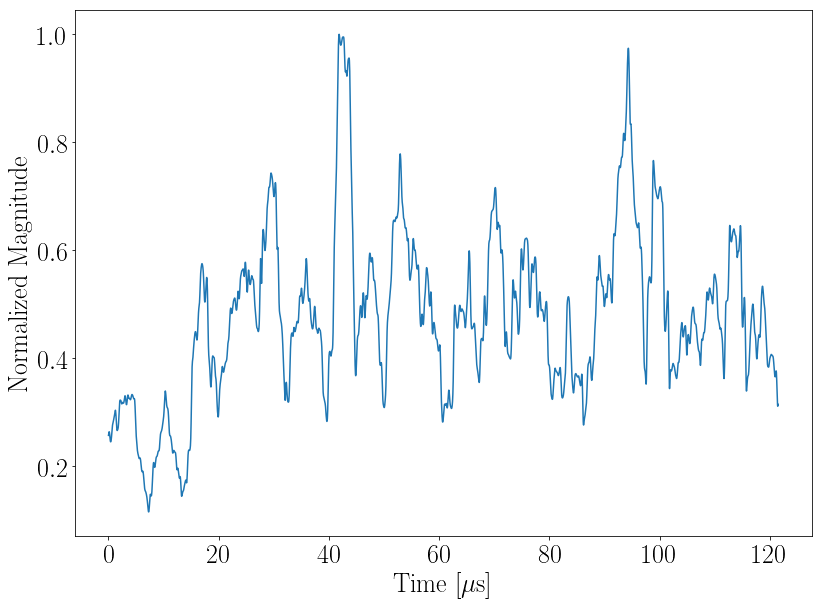

In [37]:
f0 = 0
stepFreq = 1
secondsOfData = 8.62e-6
numberOfSamples = int(secondsOfData*fs)
totalSamples = 4096

bandwidth = np.arange(1, 20+stepFreq, stepFreq)*1e6

bandwidth = np.array([1])*1e6

JNRVector = [-10]
# JNRVector = [float("inf")]

# JNRVector = [-4, -2, 0]

JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

for k in list(bandwidth):
    
    t = np.arange(0, secondsOfData - 1/fs, 1/fs)    
    f = ((k/2)/secondsOfData)*t + f0

    signal1 = np.exp(1j*2*np.pi*f*t)    
    signal1 = np.tile(signal1, np.floor(100e-6*fs).astype(int)//numberOfSamples)
    pow1 = pow_eval(signal1)
    signal1 = np.concatenate((np.zeros(totalSamples - signal1.shape[0]), signal1))

    noise = np.random.randn(len(signal1)) + 1j*np.random.randn(len(signal1))
    powNoise = pow_eval(noise)

    window_length = int(3e-6*fs)

    for j, i in enumerate(JNR):
        powAux = pow1/i
        noise2 = noise*np.sqrt(powAux/powNoise)
        data = signal1+noise2
        
#         coeffs = pywt.wavedec(data, 'db3', level=2)
#         sigma = mad( np.abs(coeffs[-2]) )
#         uthresh = sigma * np.sqrt( 2*np.log( len( HNorm ) ) )
#         coeffs[1:] = ( pywt.threshold( np.abs(i), value=uthresh, mode="soft" ) for i in coeffs[1:] )
#         data = pywt.waverec(coeffs, 'db3')
        
        cmap = plt.get_cmap('jet')
        Pxx, freqs, bins, _ = plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=nfft-1, cmap=cmap,
                                          detrend='none', sides='twosided')
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inputNMF = np.abs(Pxx)
        inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)
        specdB = 10*np.log10(inputNMF)
        
        if j == 0:
            vmin = np.min(specdB)
            vmax = np.max(specdB)
            
        v = ax.pcolormesh(bins*1e6, freqs/1e6, specdB, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_ylabel('Frequency [MHz]')
        ax.set_xlabel('Time [$\mu$s]')
        fig.colorbar(v).ax.set_ylabel('[dB]')
        plt.tight_layout()
        saveFig(fig, figPath, ''.join(['spec_input_band', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                           str(int(k/1e6))]), save_fig=save_fig)
        plt.show()

        model = NMF(init='nndsvda', max_iter=10000, verbose=0, random_state=1, tol=1e-16, 
                      beta_loss=beta_loss, n_components=1, solver='mu')
        W = model.fit_transform(inputNMF)
        H = model.components_

        for l in range(H.shape[0]):
            HNorm = H[l,:]/np.max(H[l,:])
            H2 = mean_window(HNorm, window_length)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(bins*1e6, HNorm)
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_band', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                           str(int(k/1e6))]), save_fig=save_fig)
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            taux = np.linspace(0, H2.shape[0]/fs, H2.shape[0])*1e6
            ax.plot(taux, H2/np.max(H2))
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_band', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                           str(int(k/1e6)),'_window']), save_fig=save_fig)
            plt.show()
            #################################
            
            
#             foooo = ndimage.filters.gaussian_filter1d(HNorm,
#                                                             4, axis=-1, order=0, 
#                                                             output=None, mode='reflect')
            
#             obj = Differentiator(filt_length=window_length+1, window=np.blackman(window_length+1))
#             a = H2/np.max(H2)
#             diff_mean =  obj.diff_eval(a)
#             diff = obj.diff_eval(foooo)
#             diff = diff[window_length+1:]
#             diff_mean = diff_mean[window_length+1:]
#             plt.figure()
#             plt.title('Derivative')
#             plt.plot(diff_mean)
#             plt.plot(diff)
#             ##Not working
#             coeffs = pywt.wavedec(HNorm, 'db3', level=2)
#             sigma = mad( coeffs[-2] )
#             uthresh = sigma * np.sqrt( 2*np.log( len( HNorm ) ) )
#             coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeffs[1:] )

# #             cA, cD2, cD1 = coeffs
# #             cD1 = np.where(np.abs(cD1) > np.var(cD1), 0, cD1)
# #             cD2 = np.where(np.abs(cD2) > np.var(cD2), 0, cD2)
# #             plt.figure()
# #             plt.subplot(3,1,1)
# #             plt.plot(cA)
# #             plt.subplot(3,1,2)
# #             plt.plot(cD1)
# #             plt.subplot(3,1,3)
# #             plt.plot(cD2)
            
# #             plt.show()
#             recsignal = pywt.waverec(coeffs, 'db3')
#             plt.figure()
#             plt.plot(recsignal)
#             plt.show()
            
            
            

In [25]:
save_fig=True

# Period loop

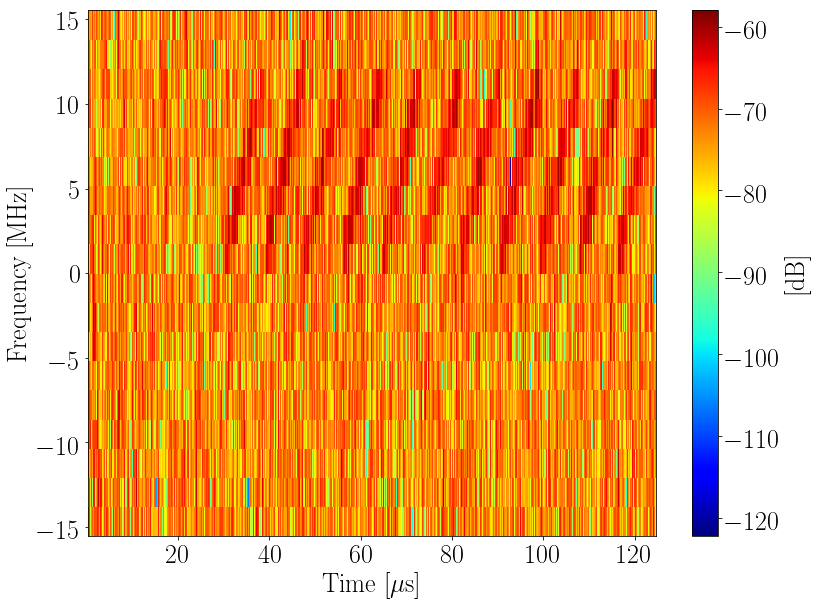

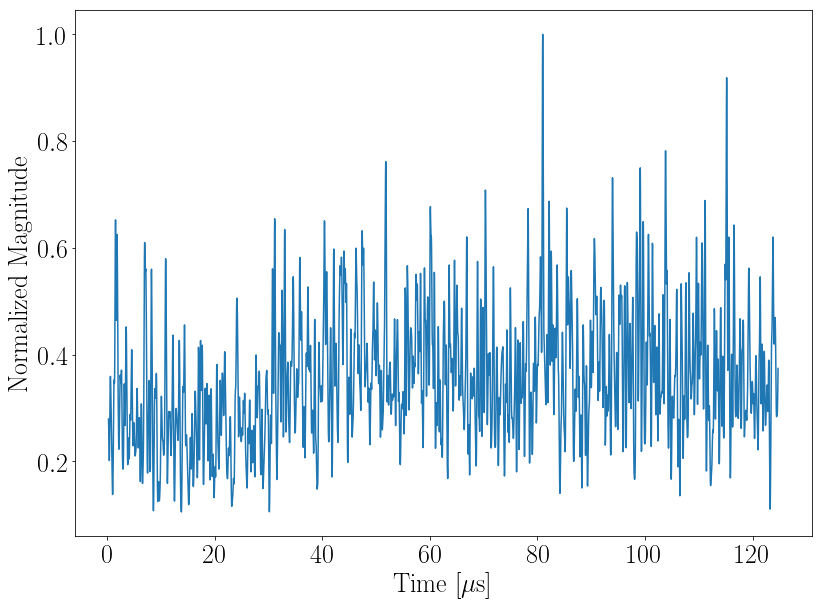

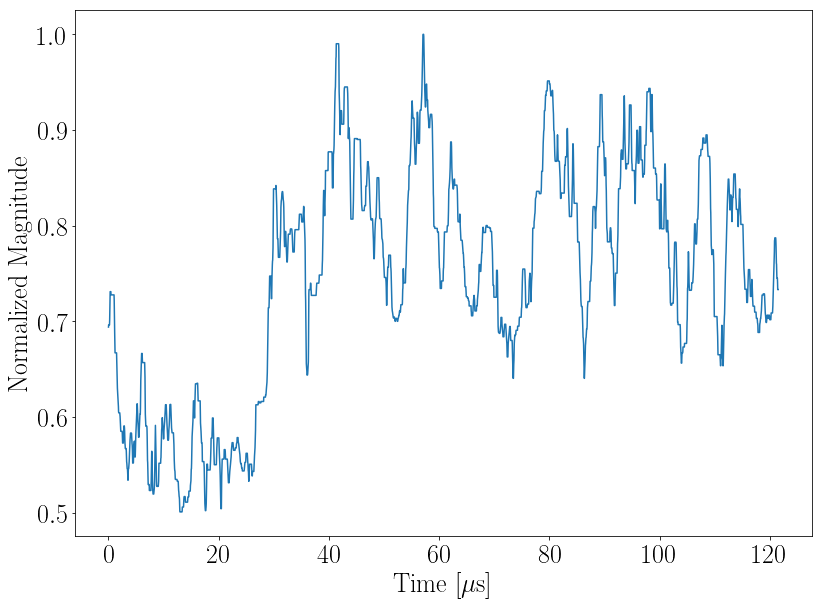

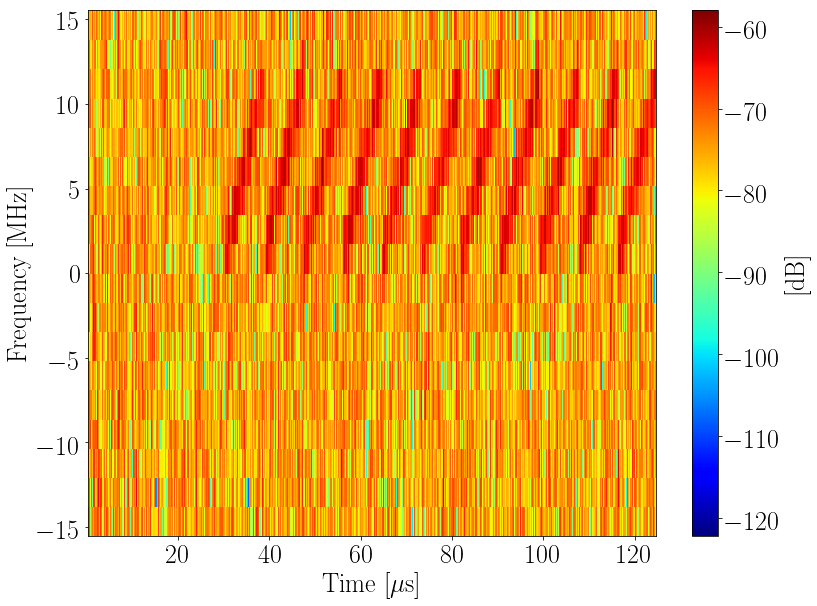

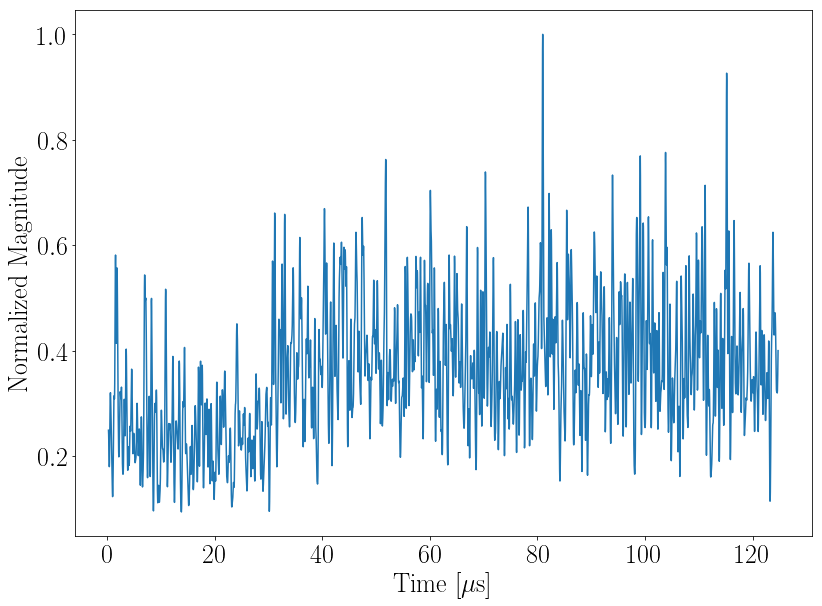

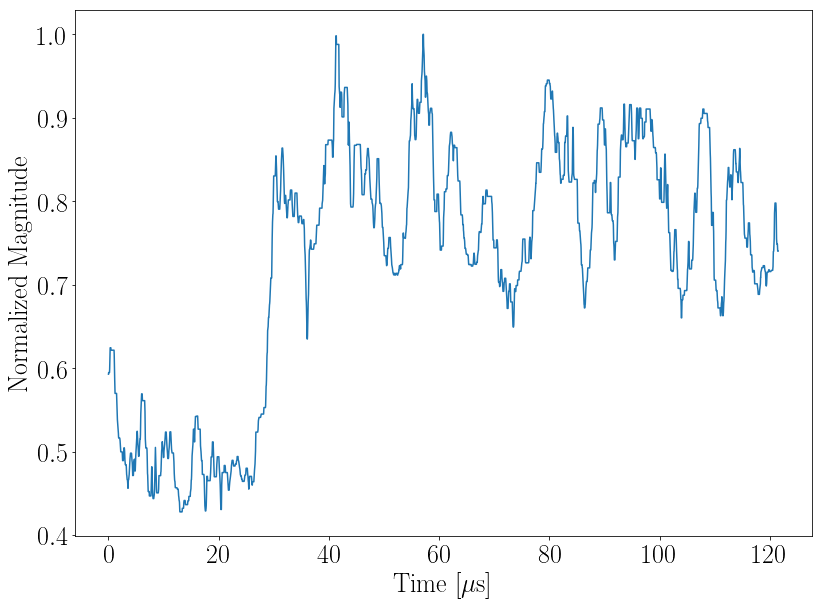

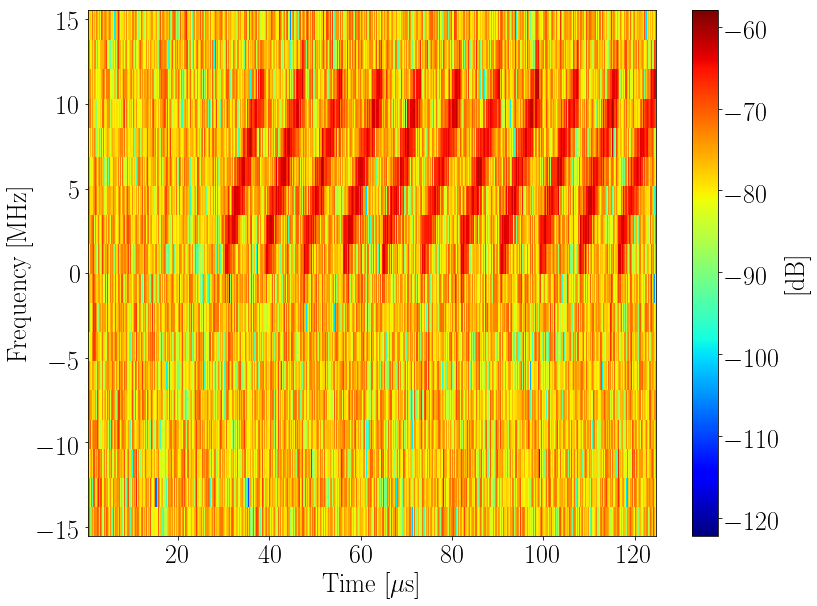

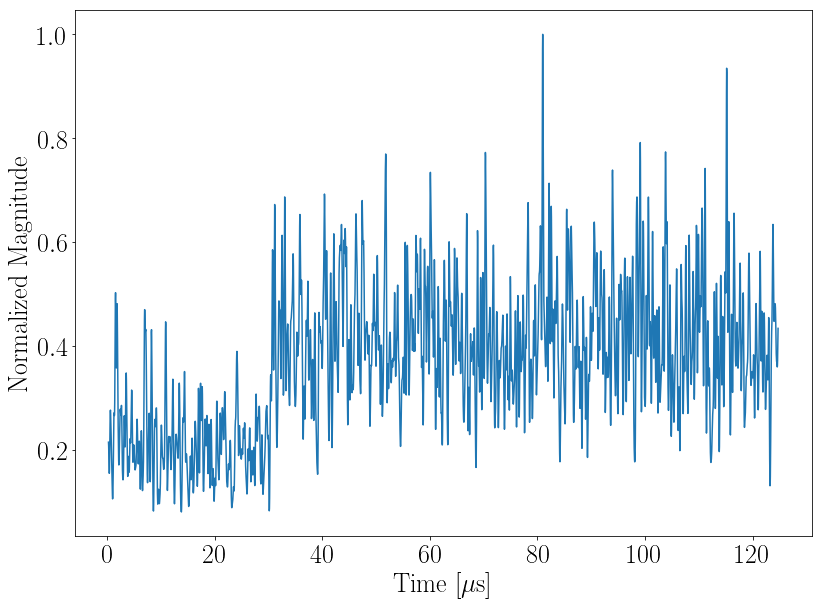

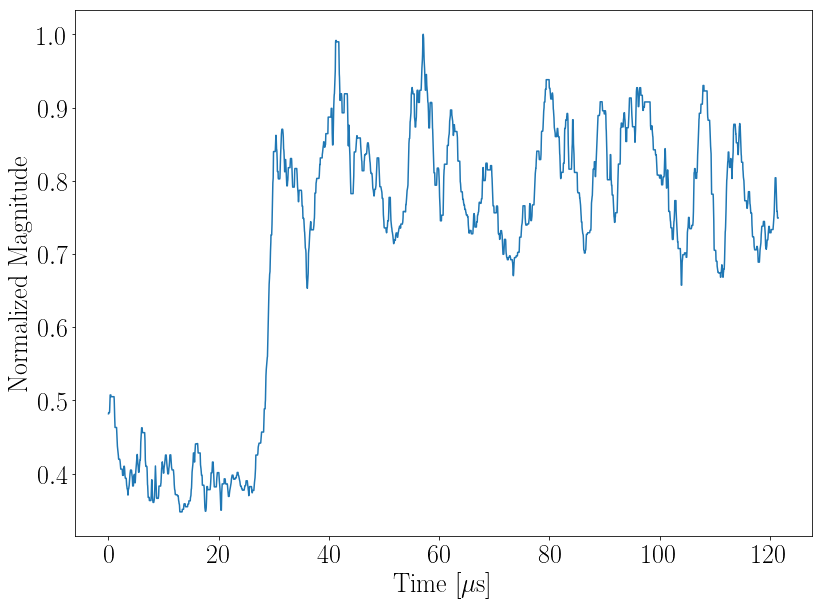

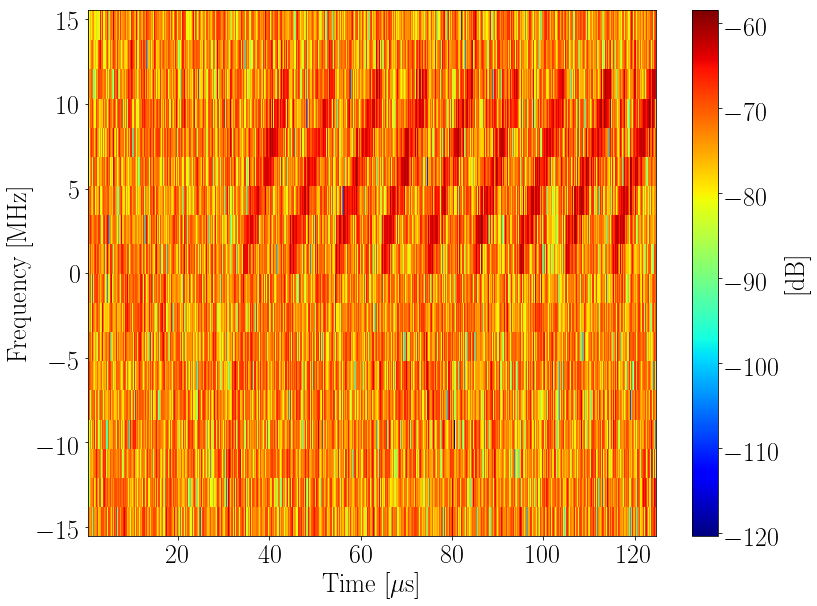

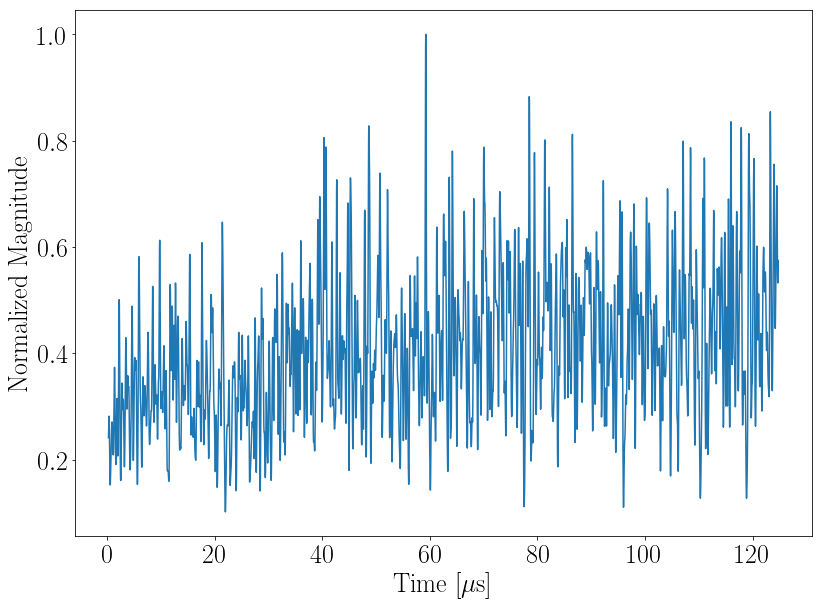

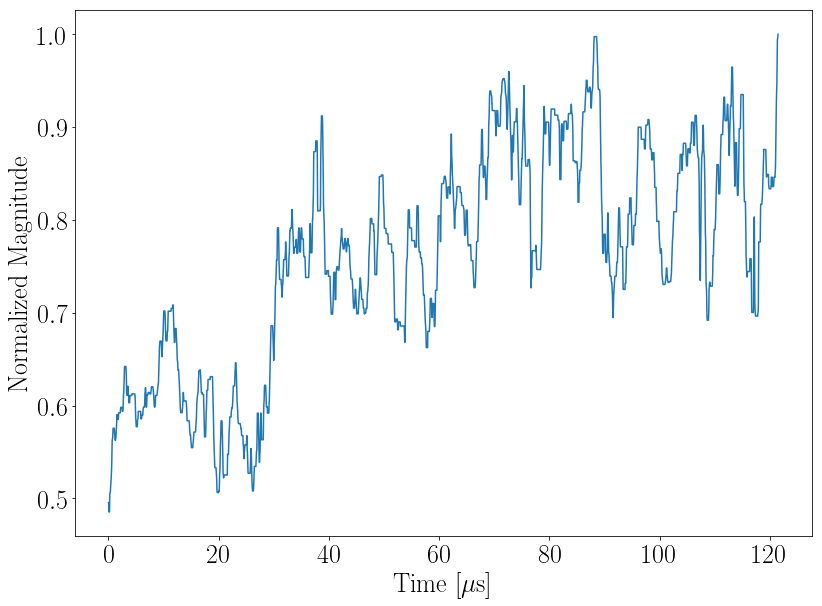

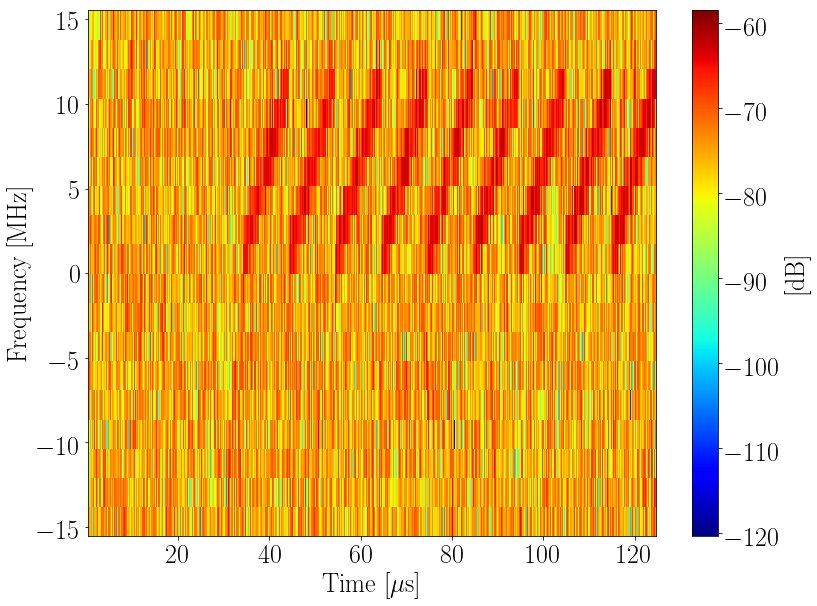

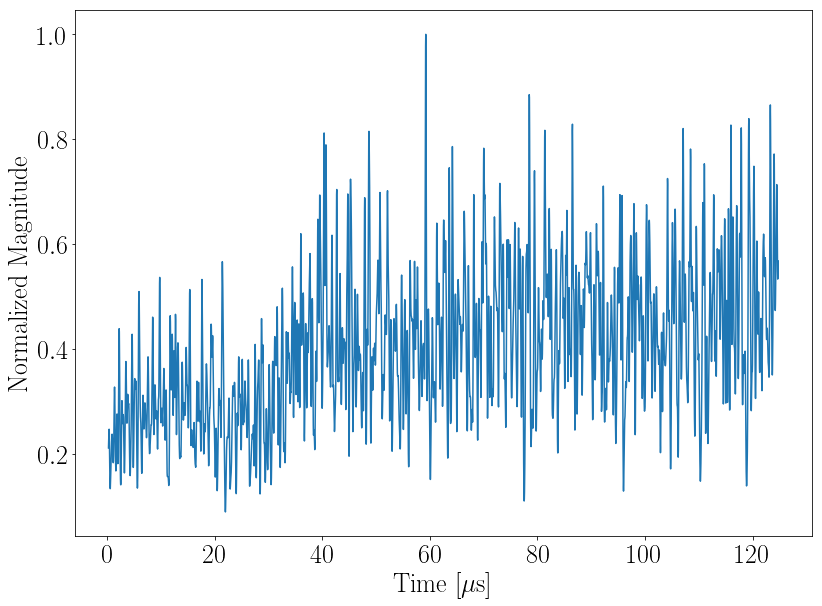

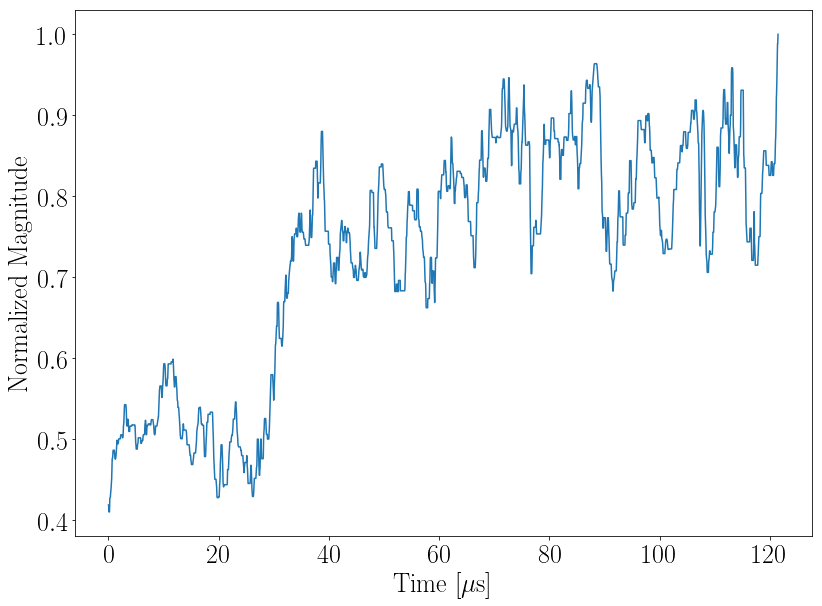

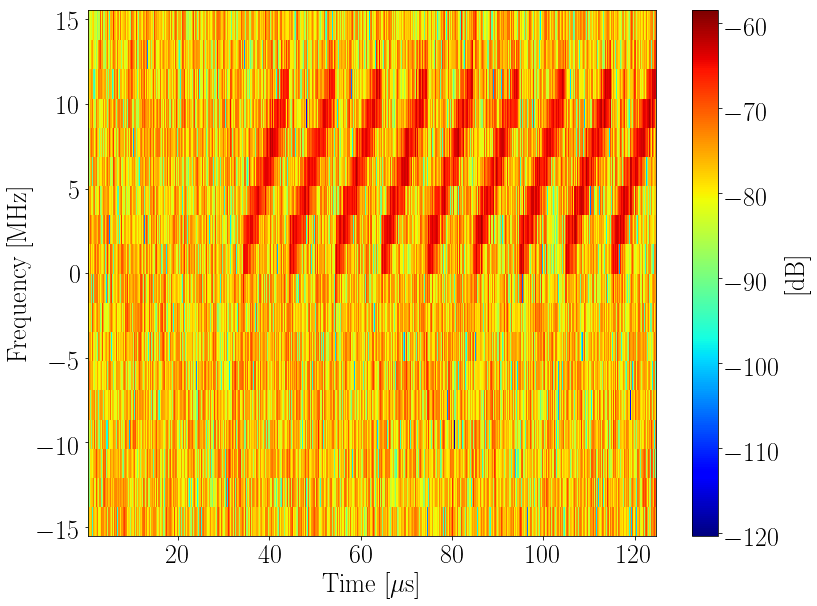

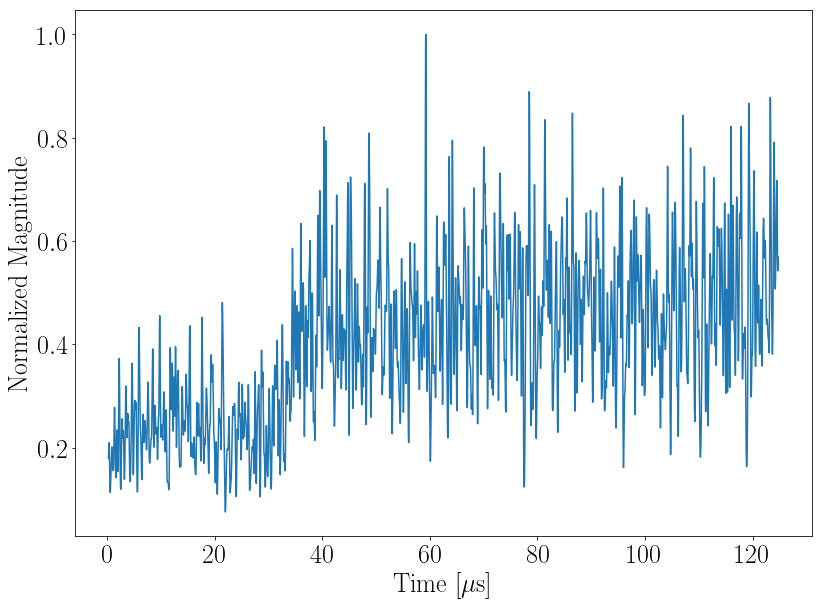

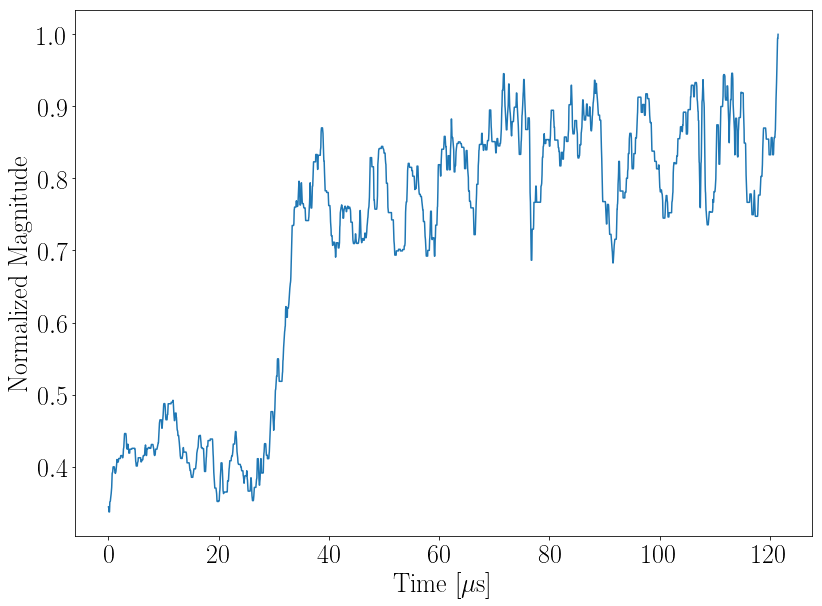

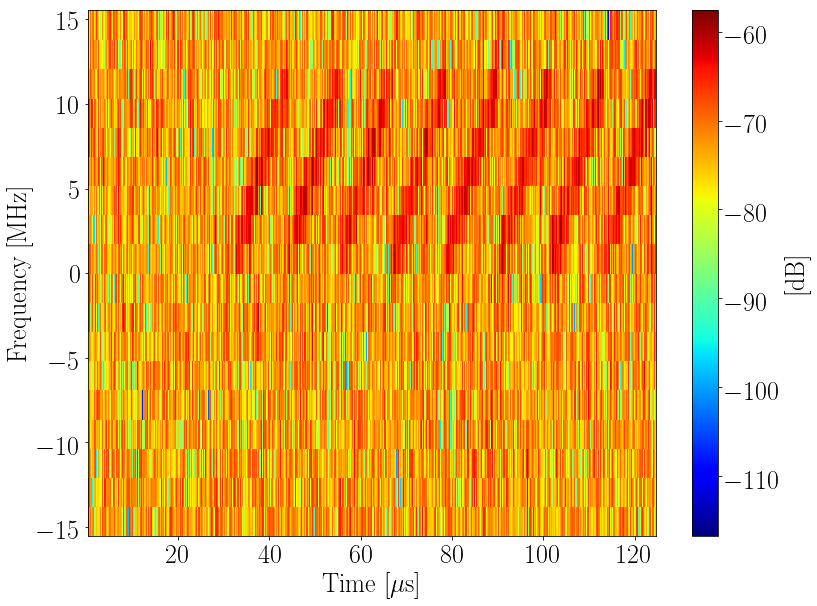

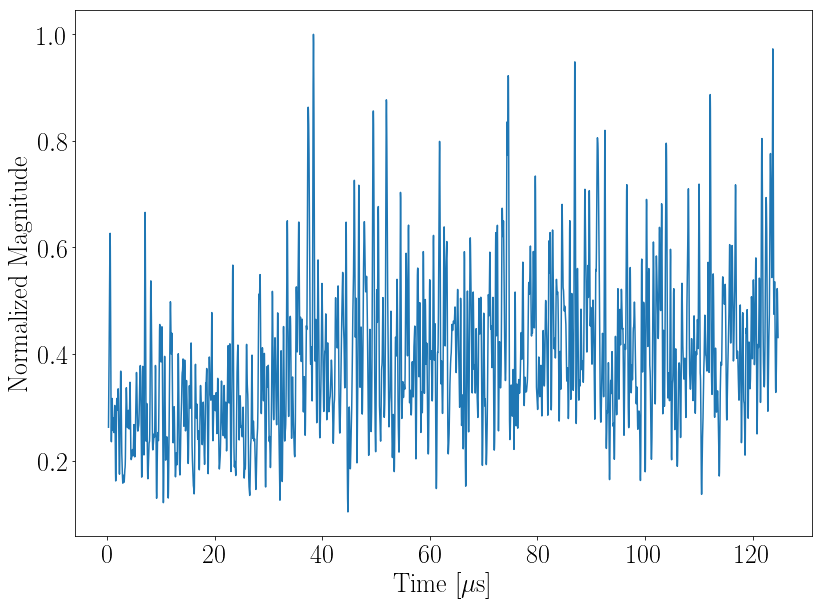

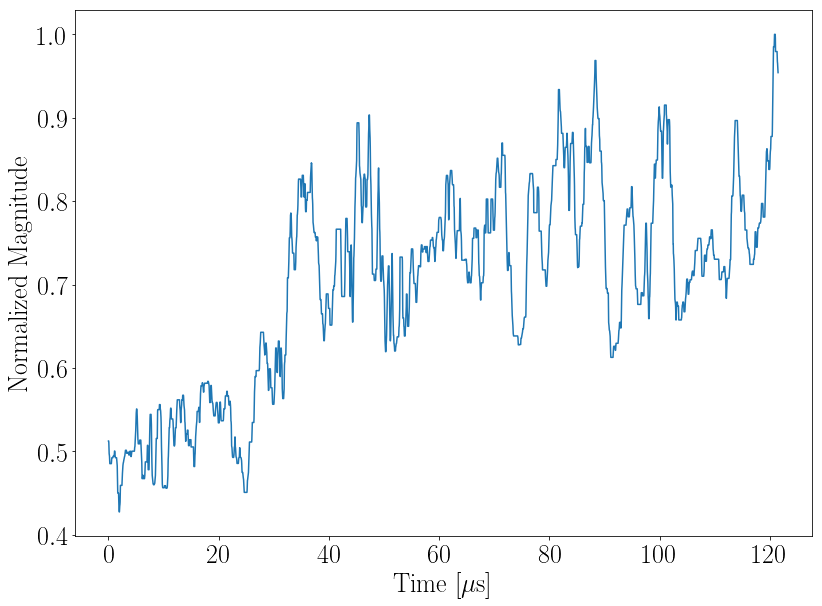

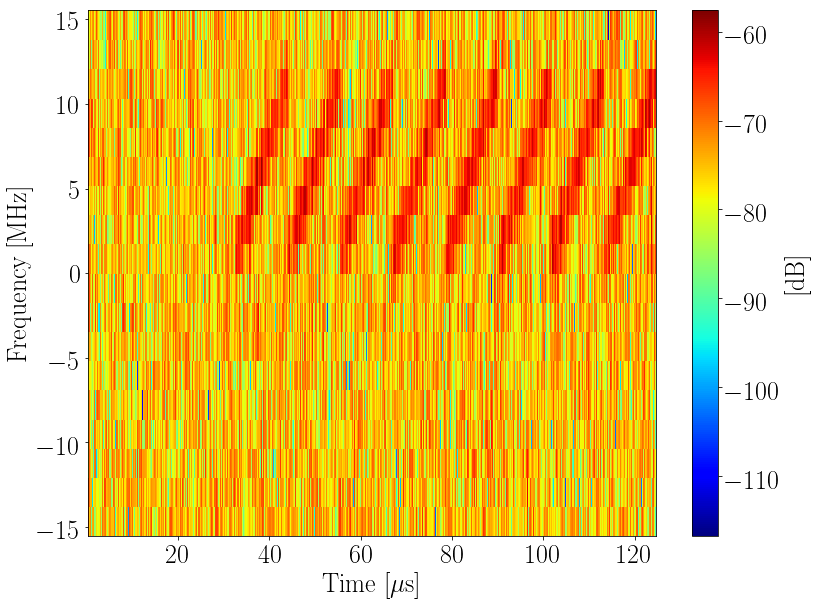

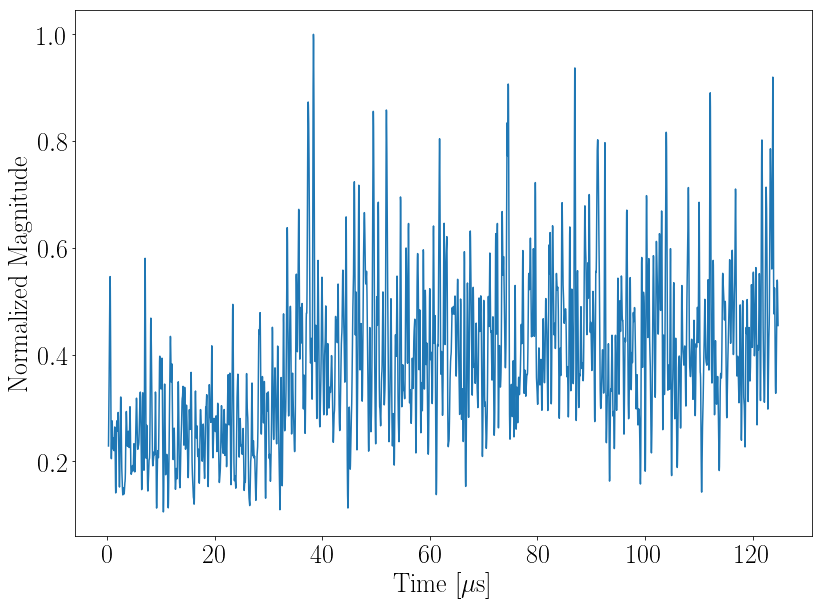

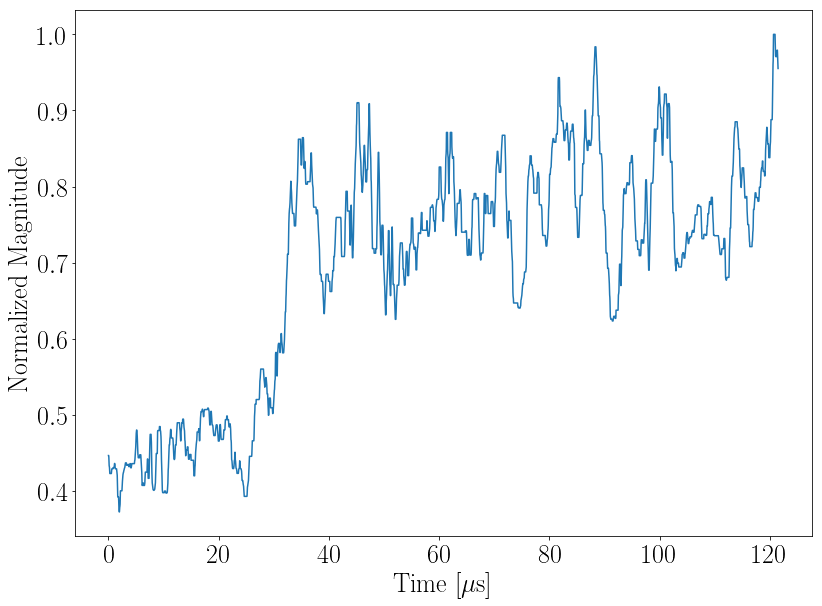

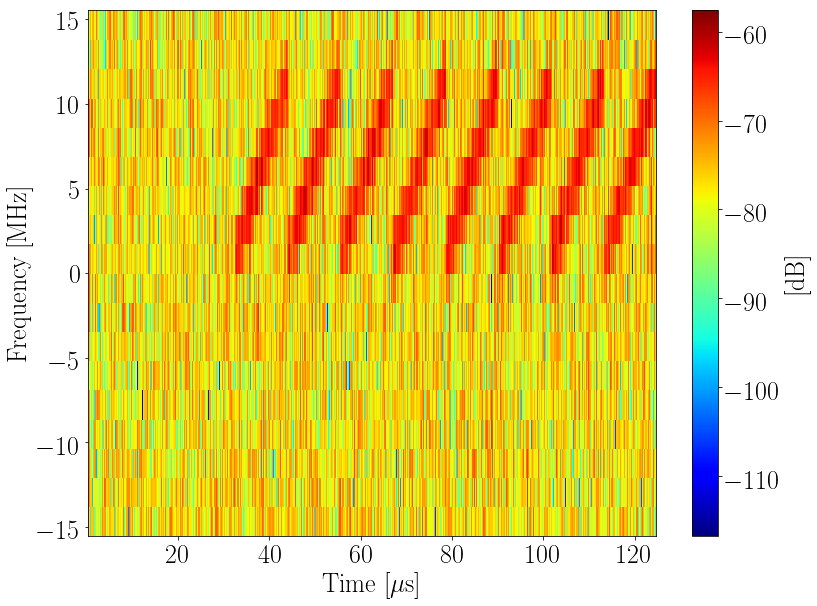

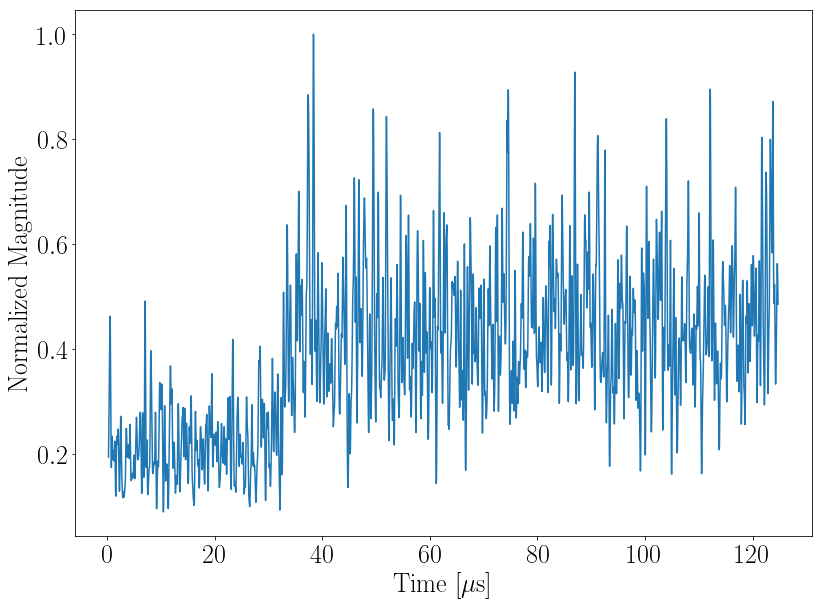

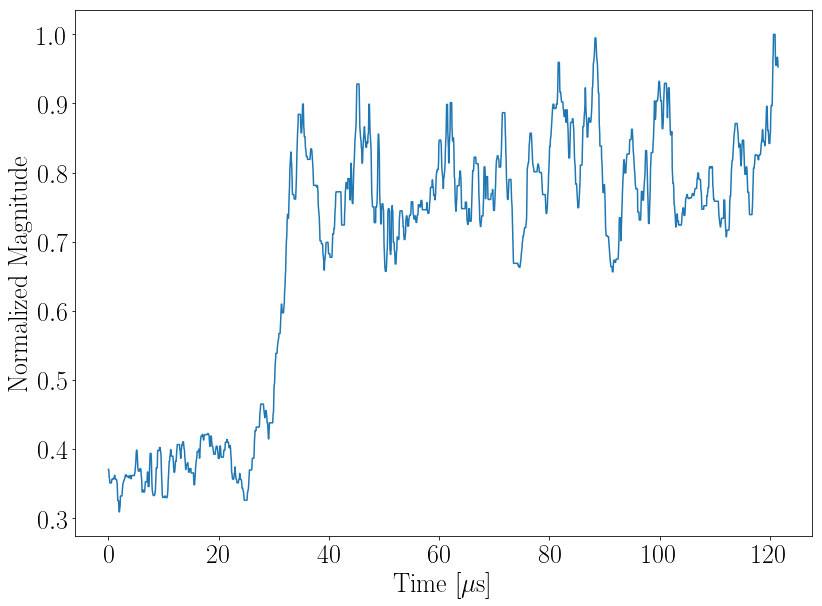

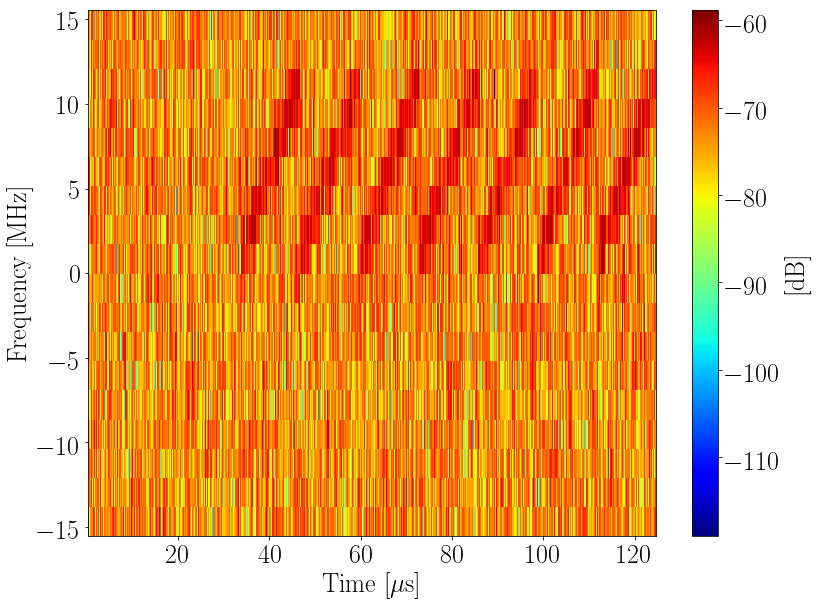

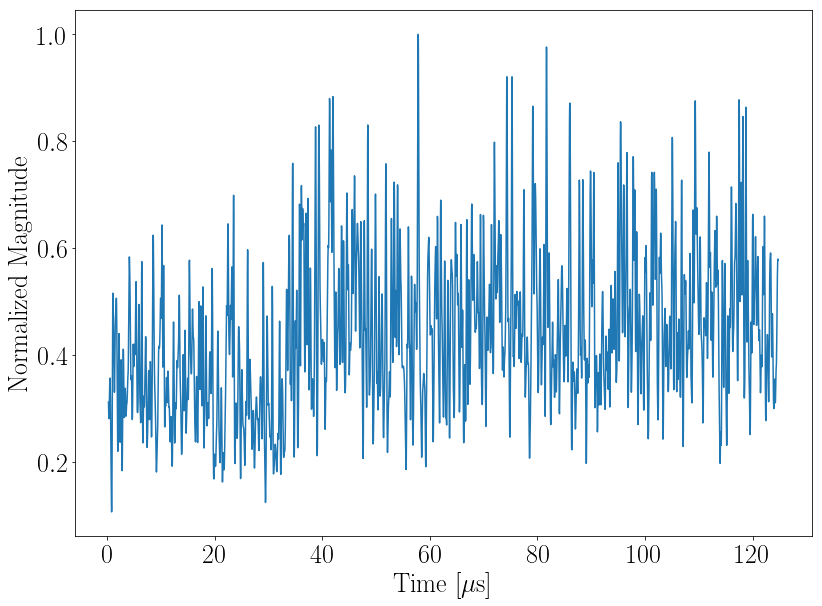

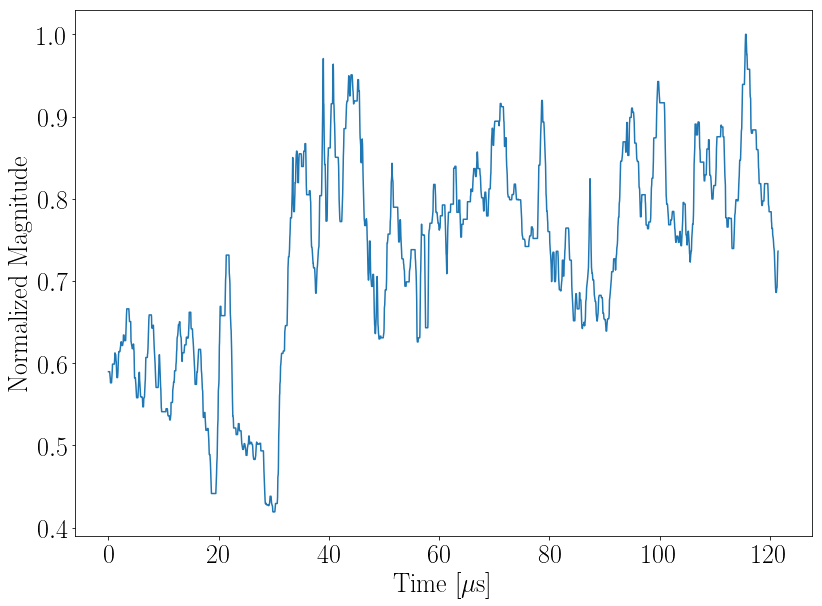

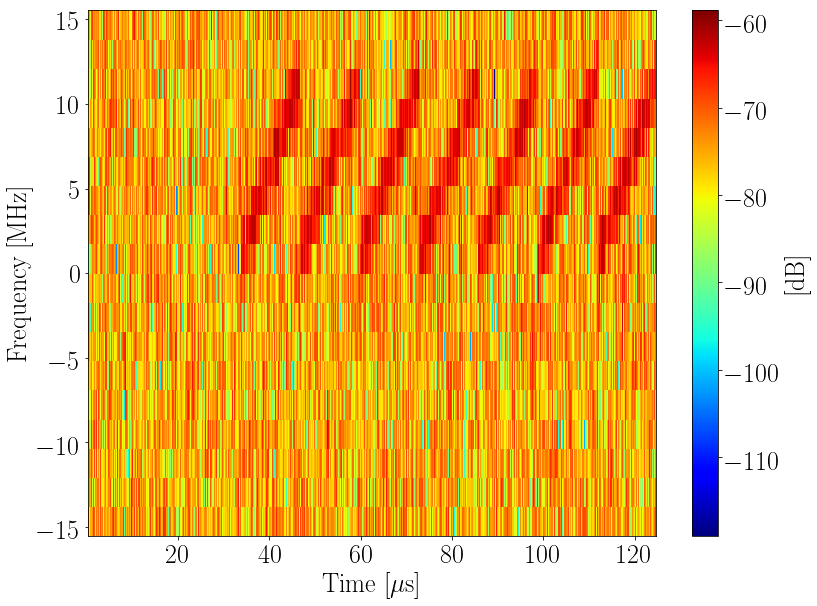

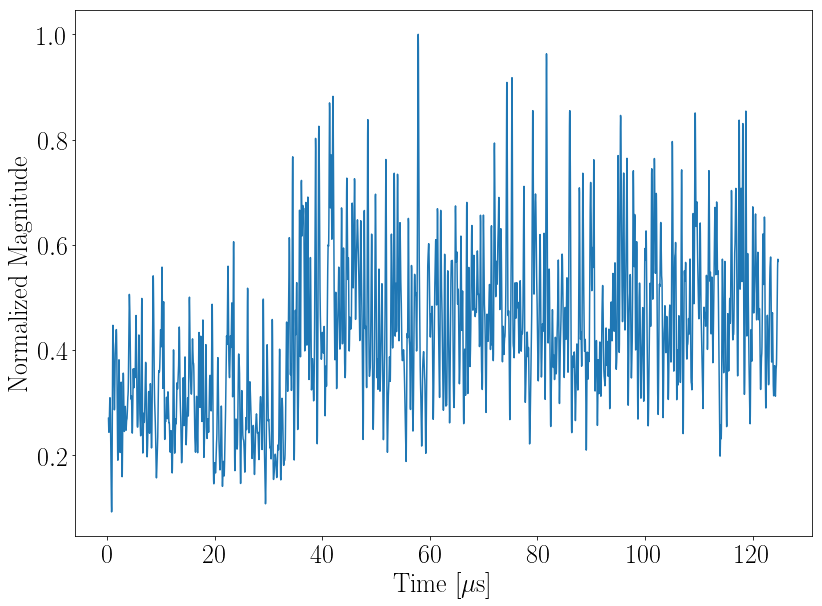

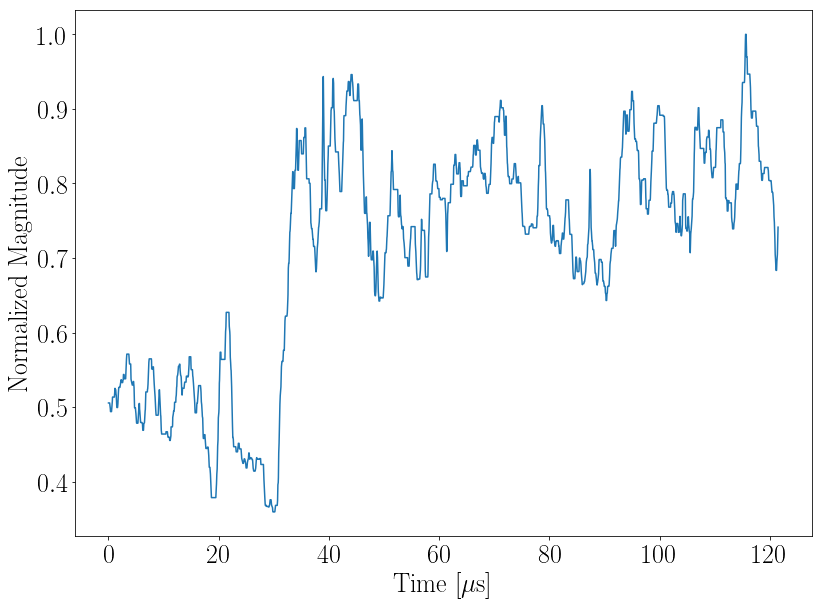

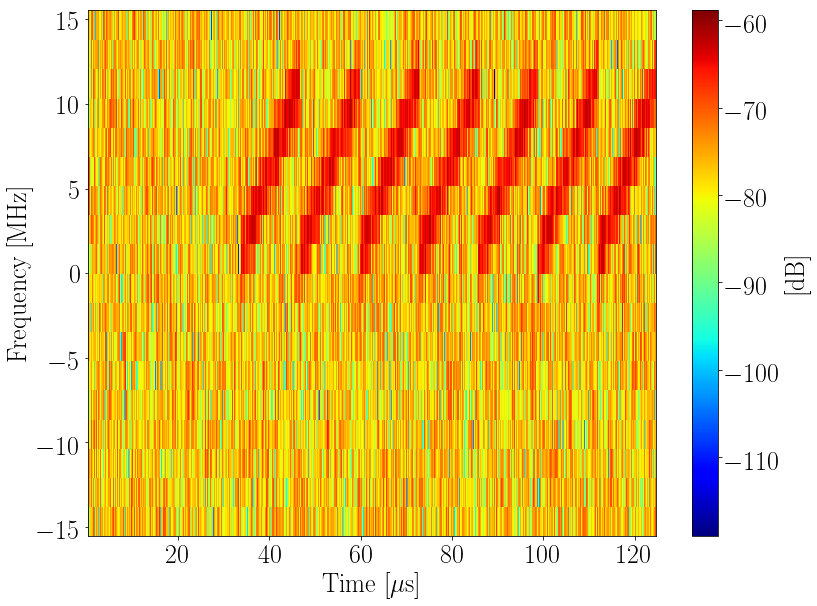

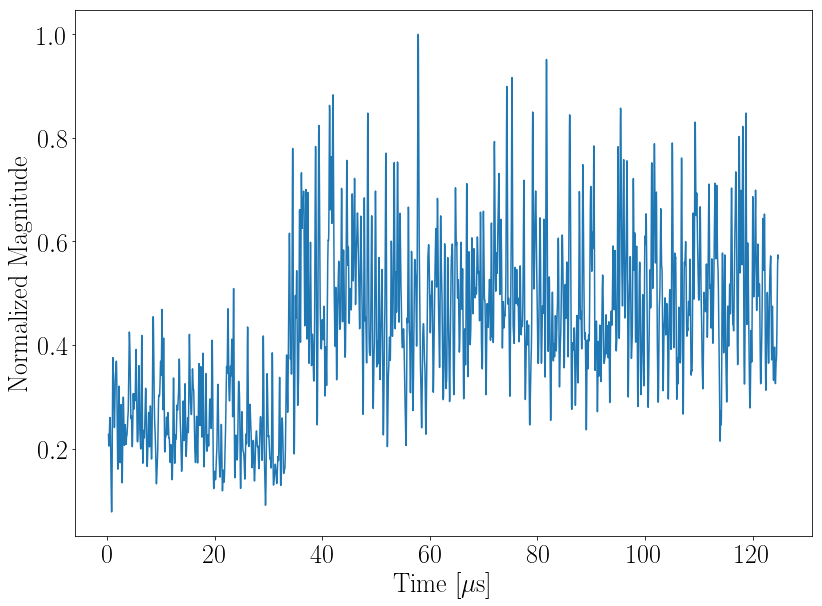

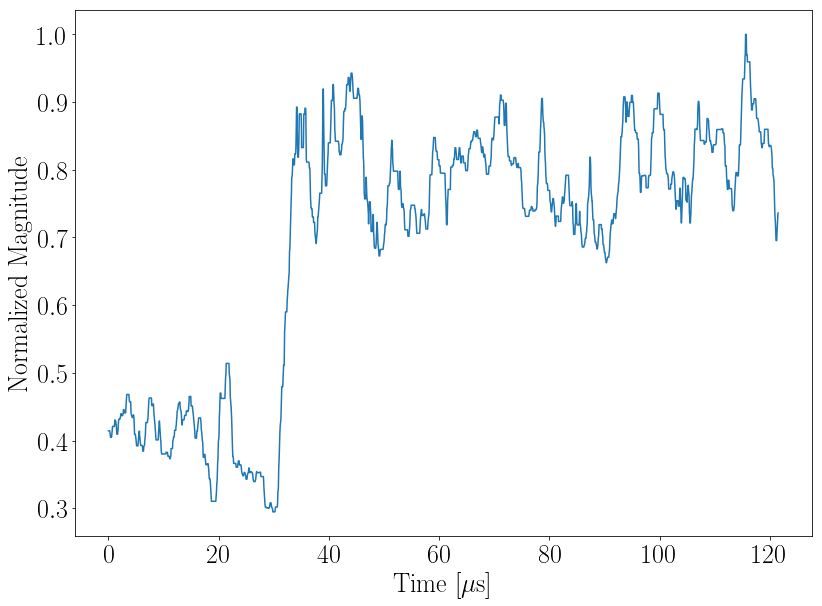

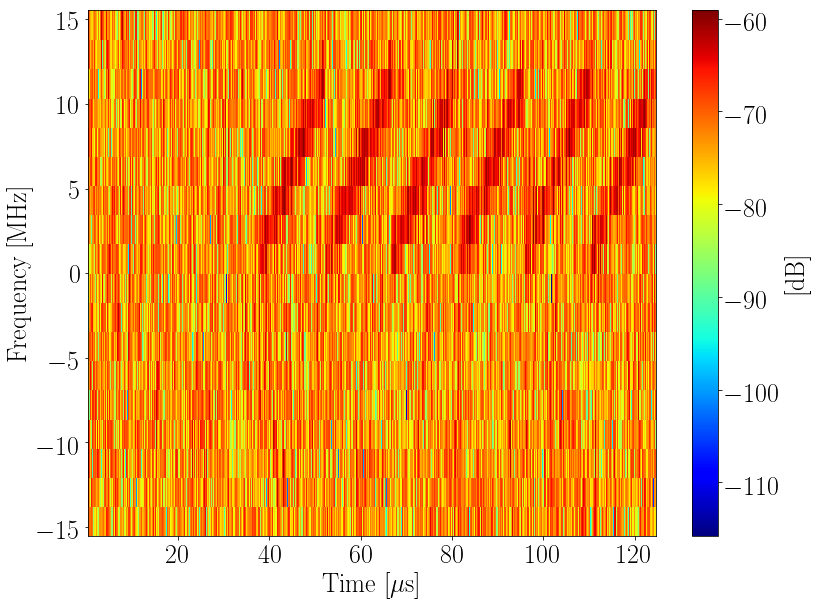

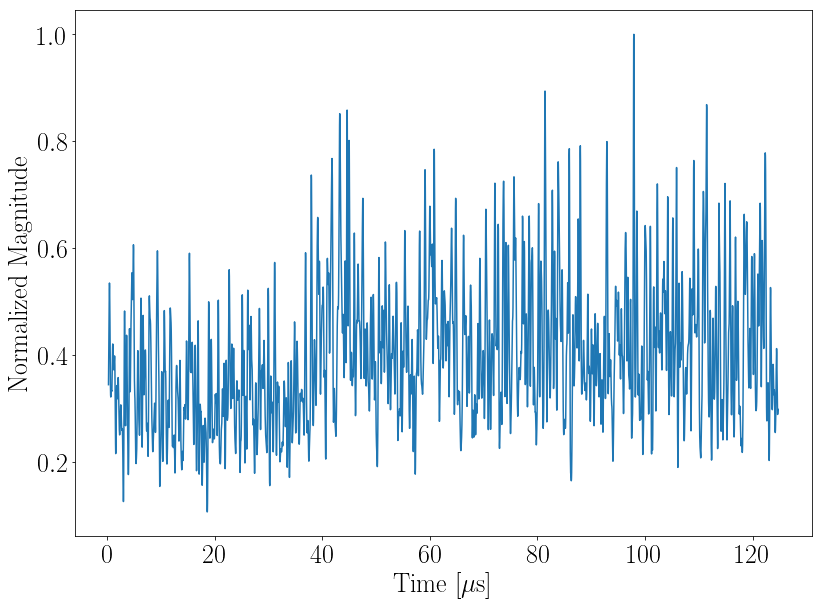

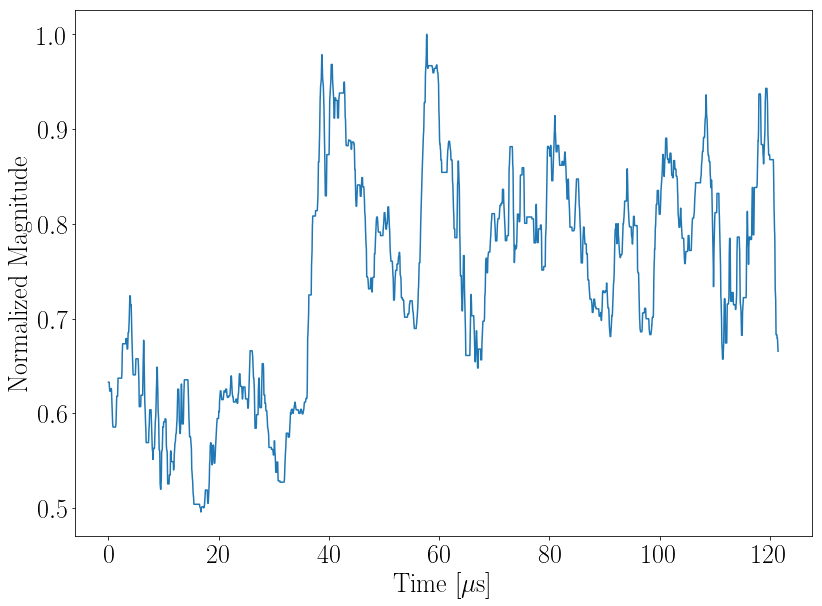

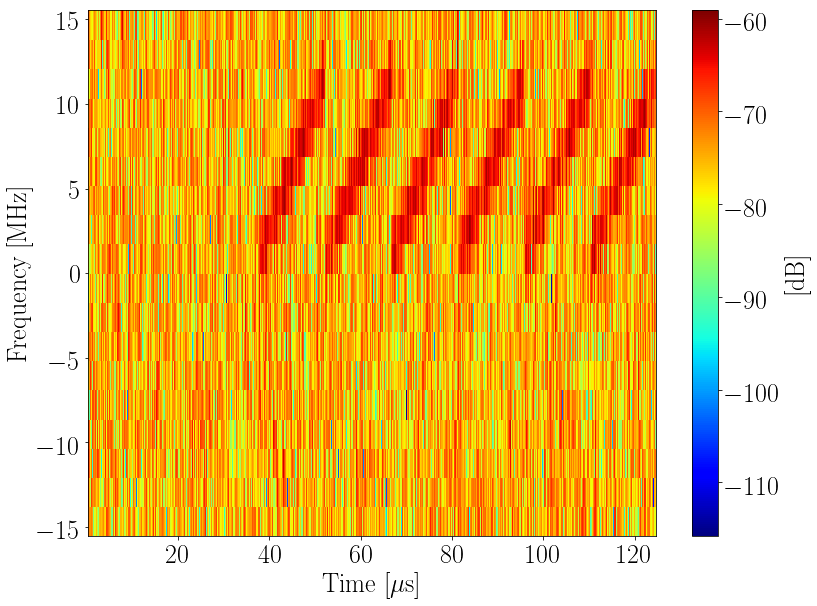

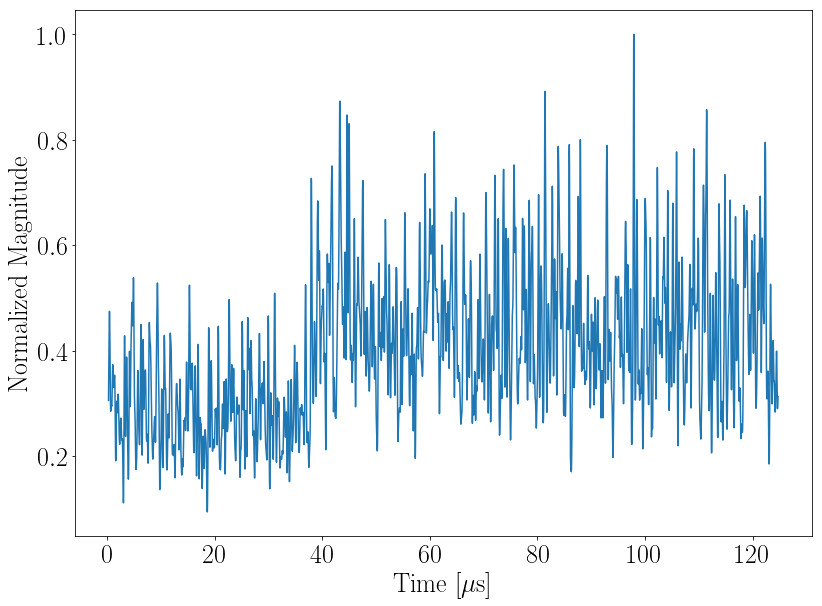

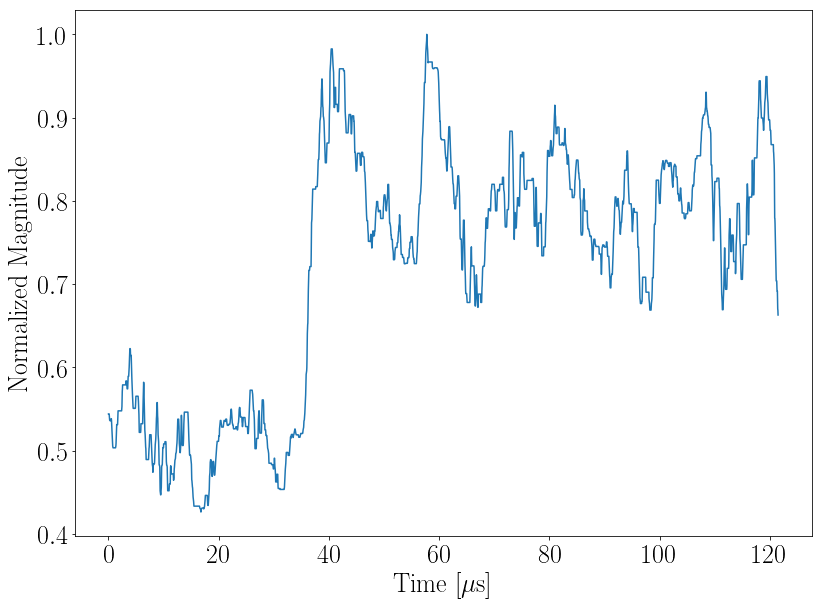

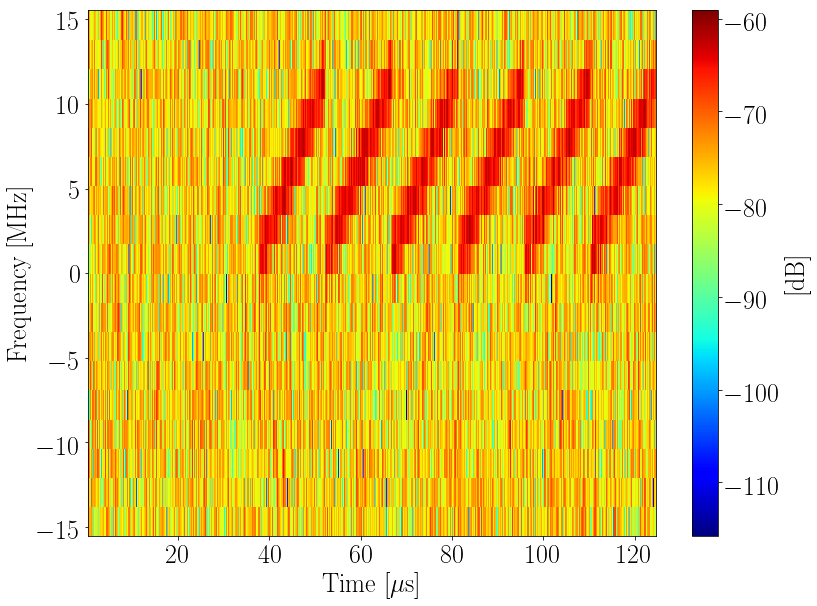

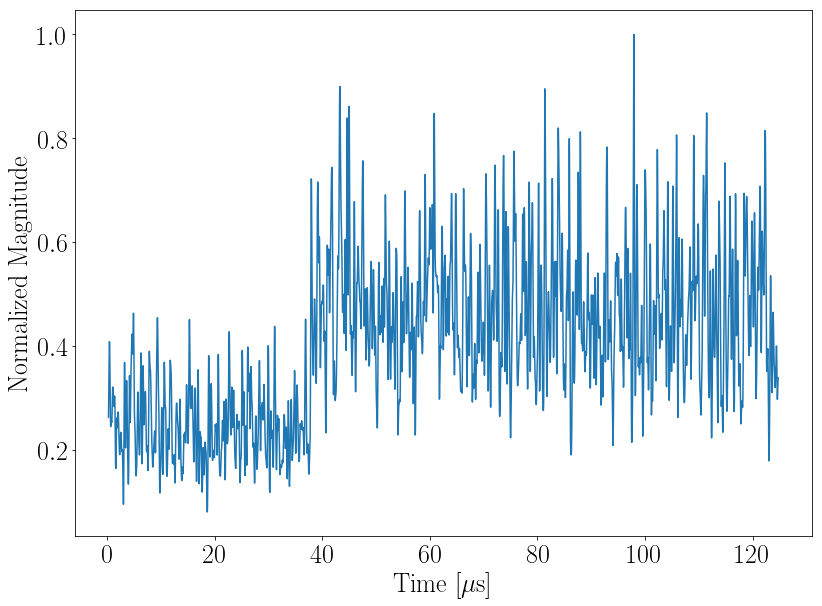

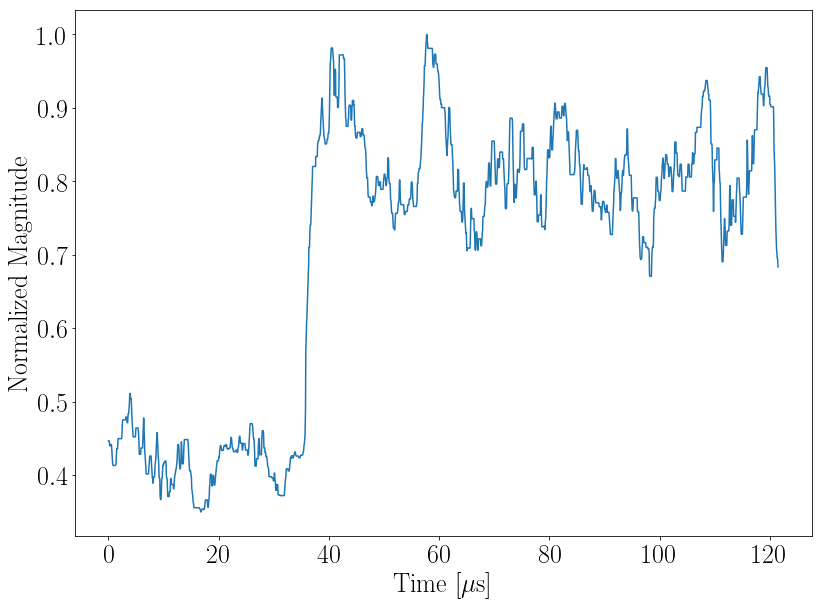

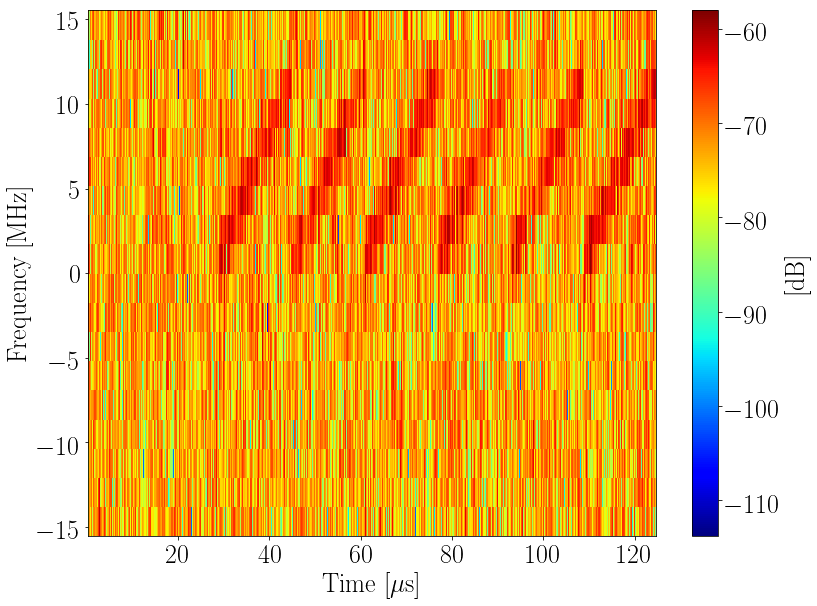

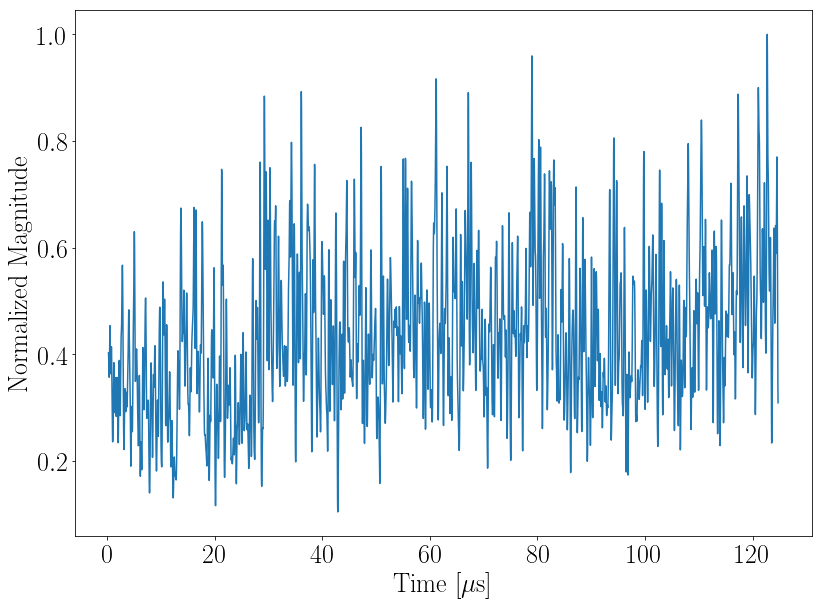

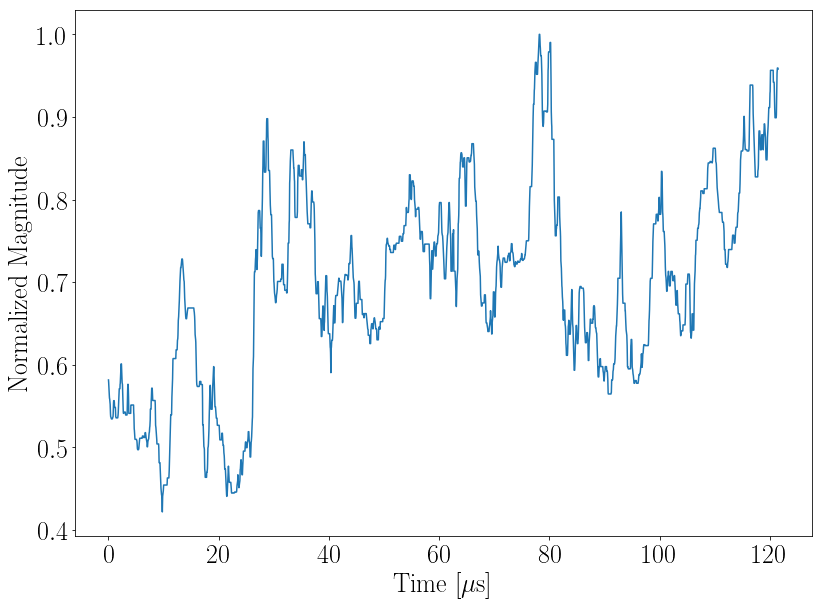

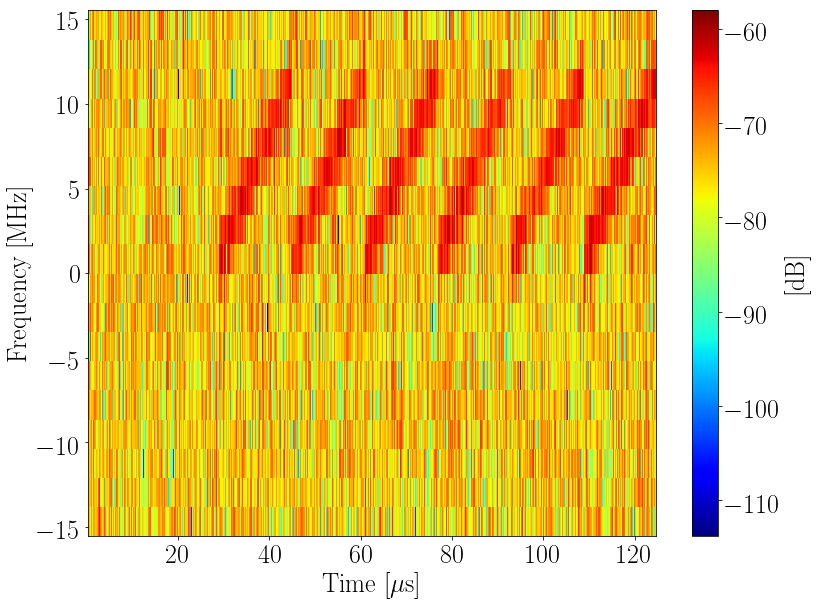

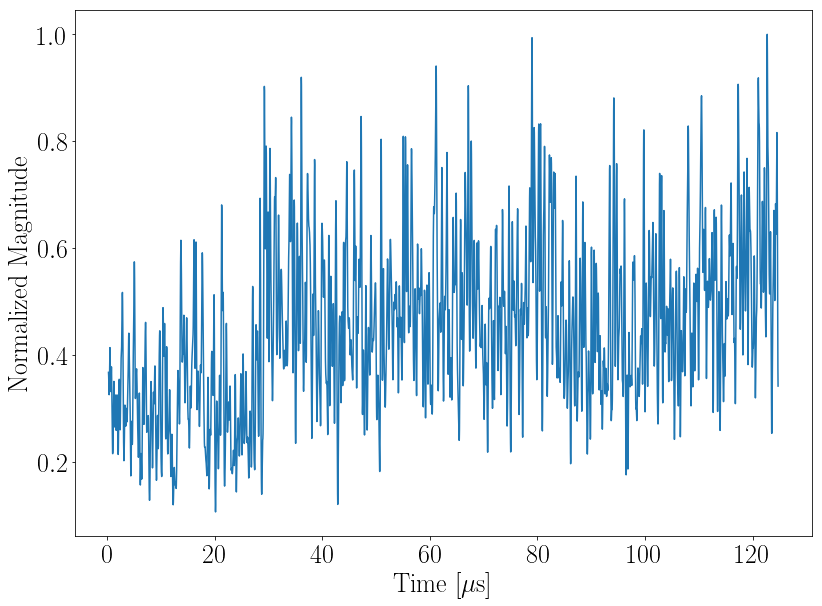

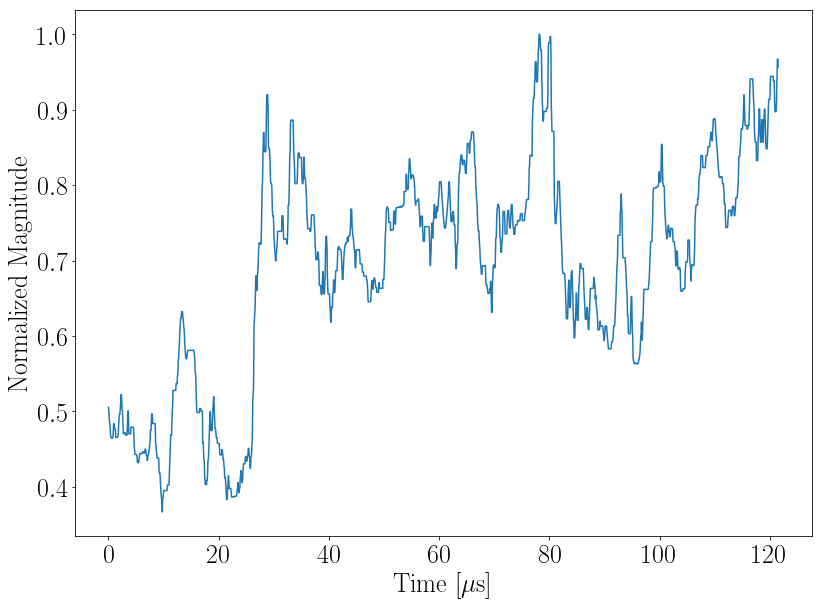

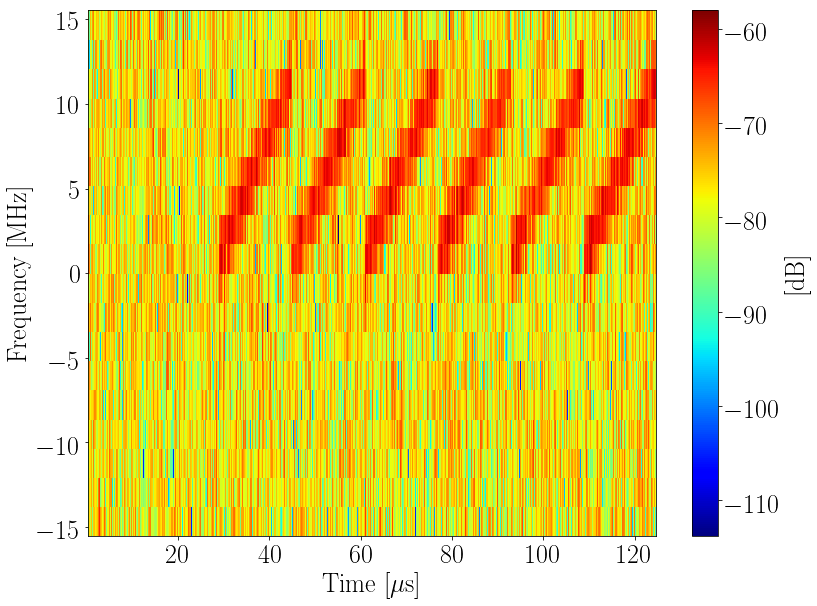

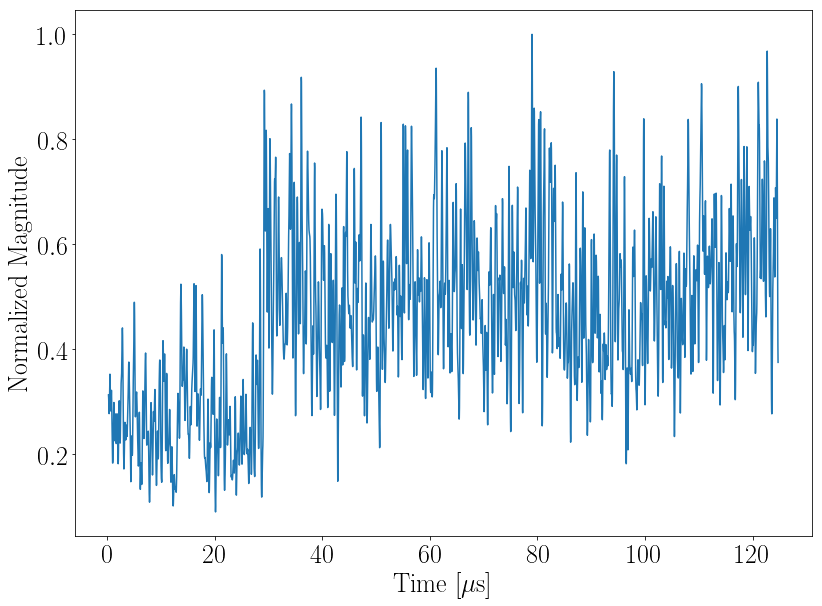

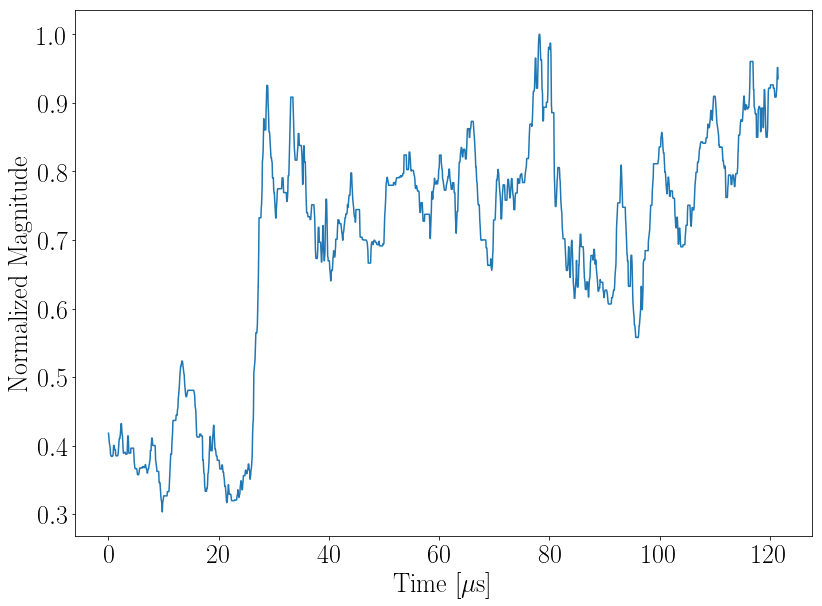

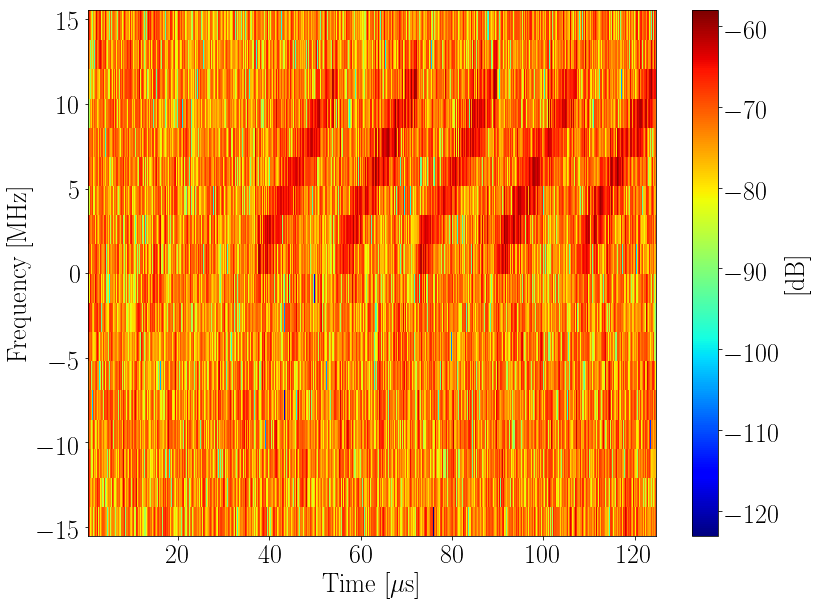

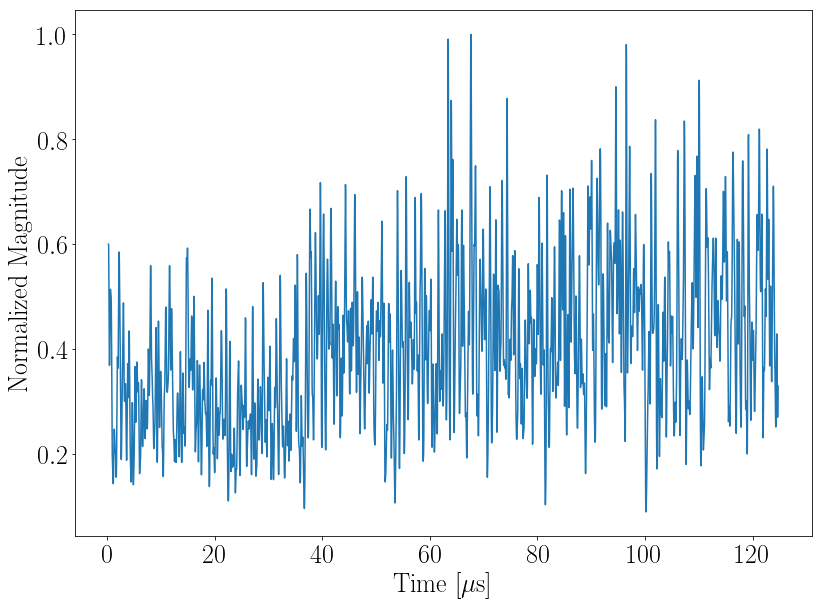

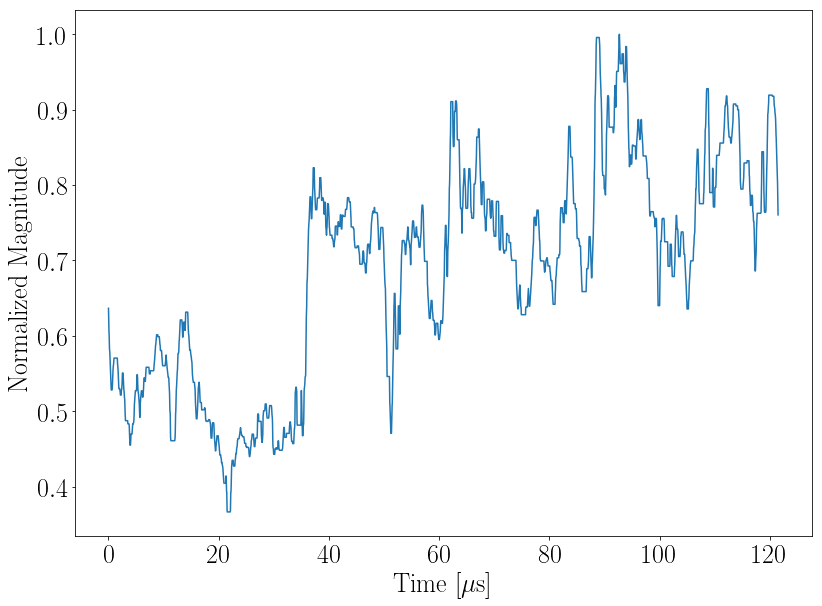

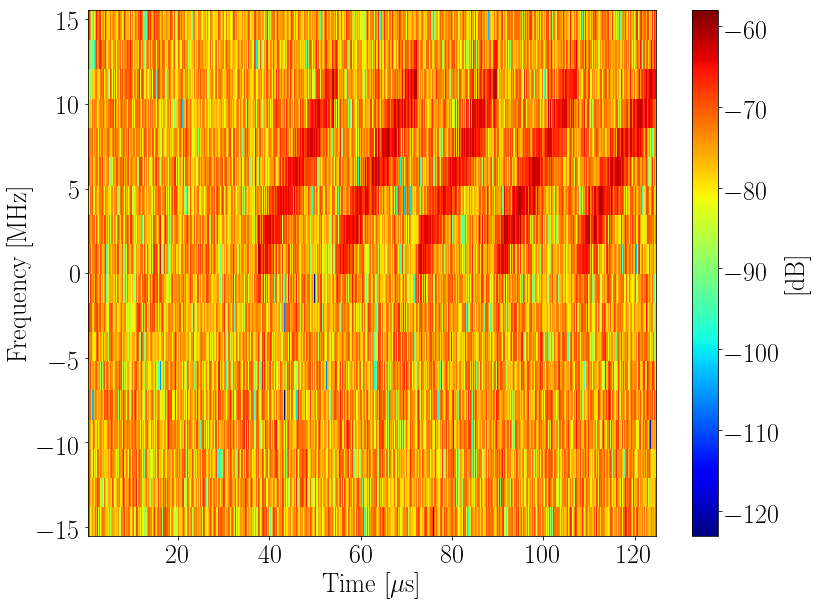

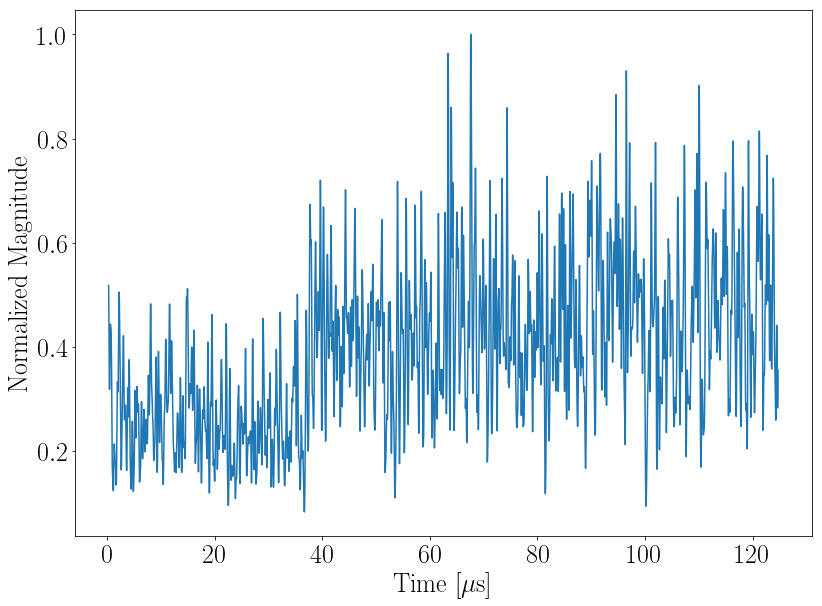

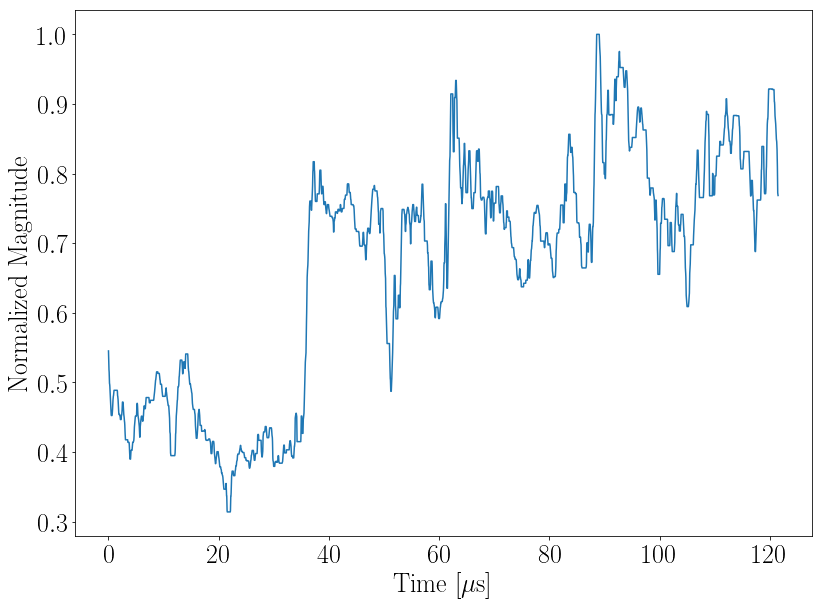

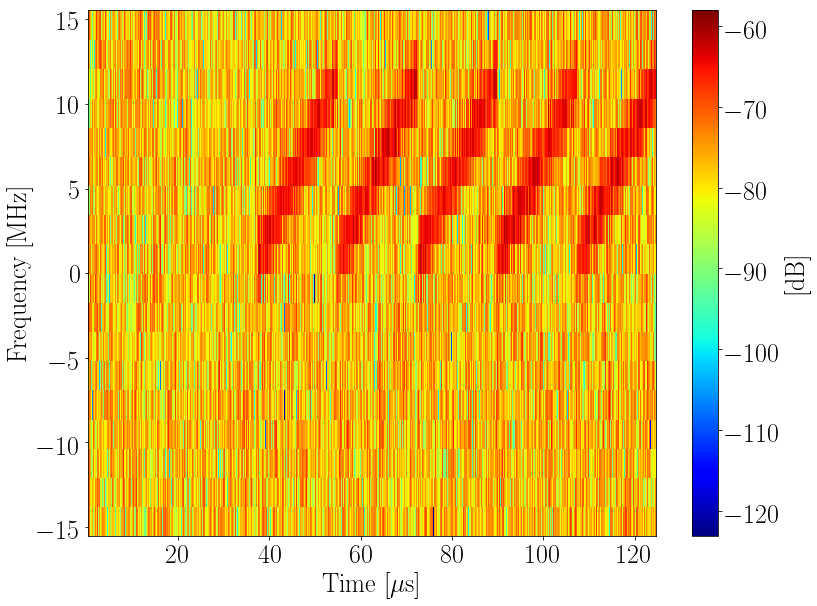

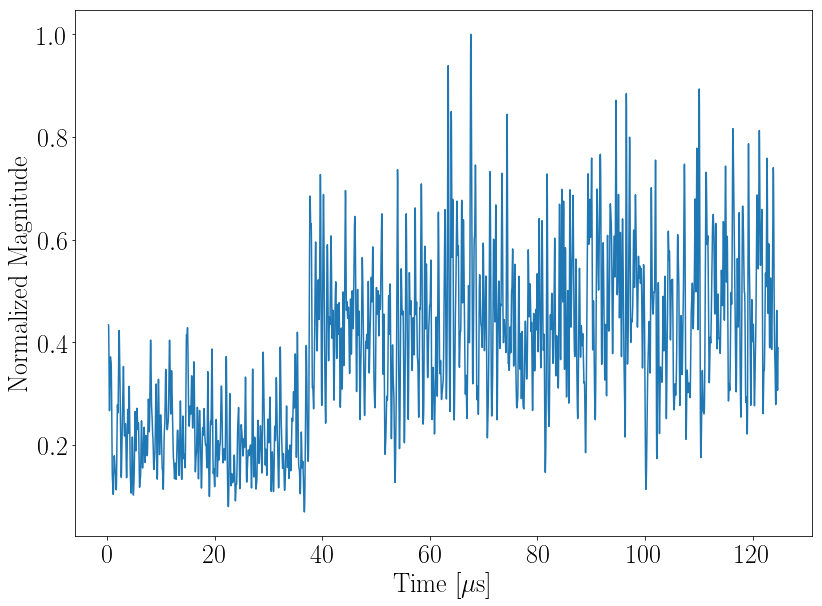

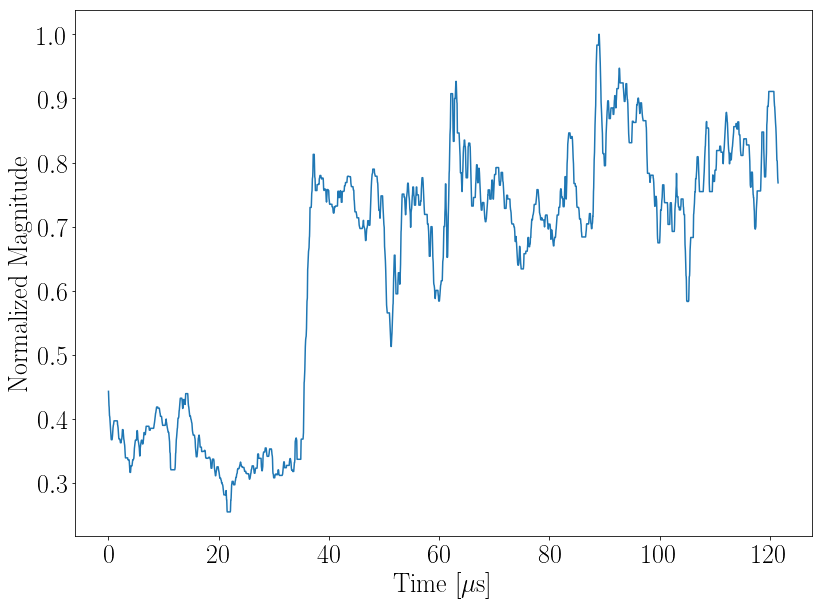

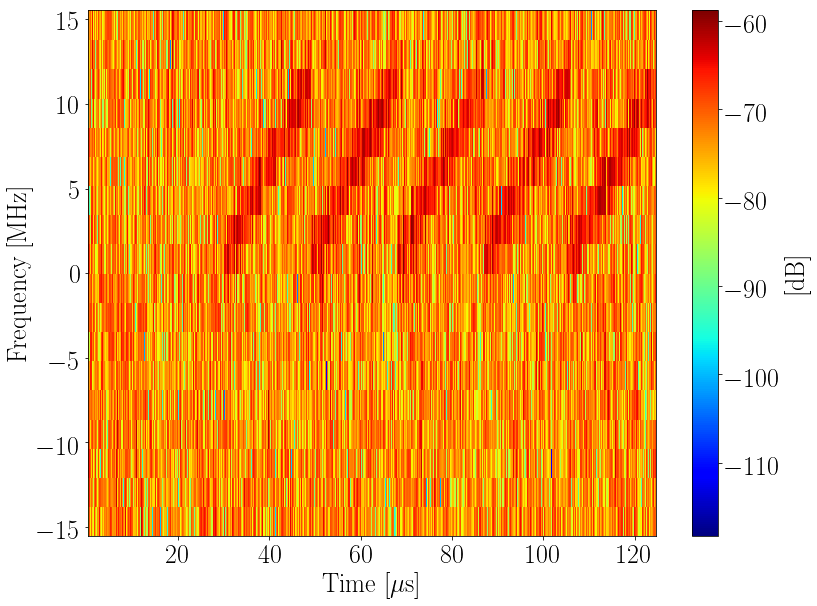

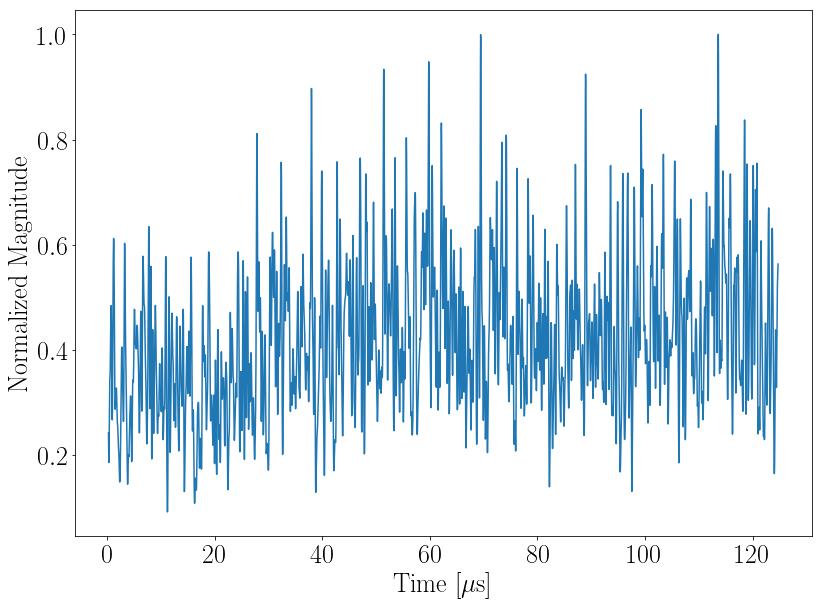

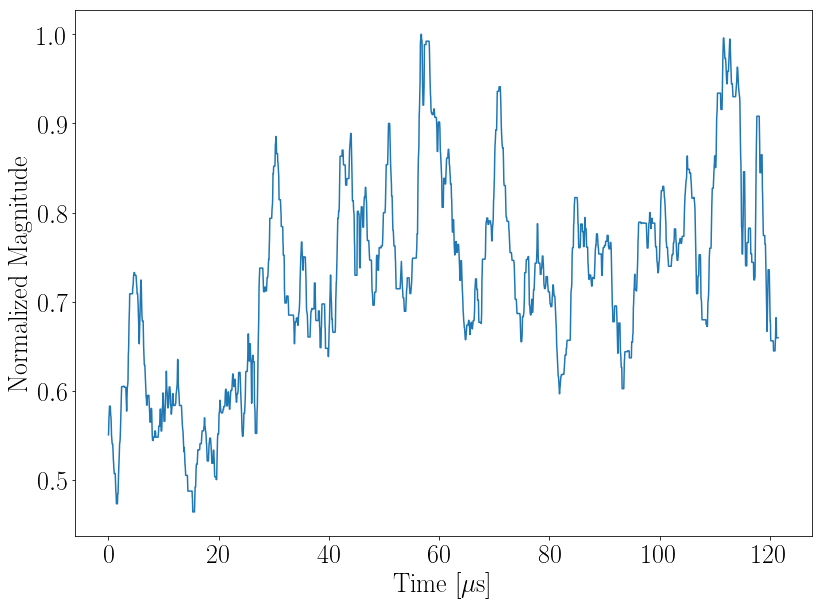

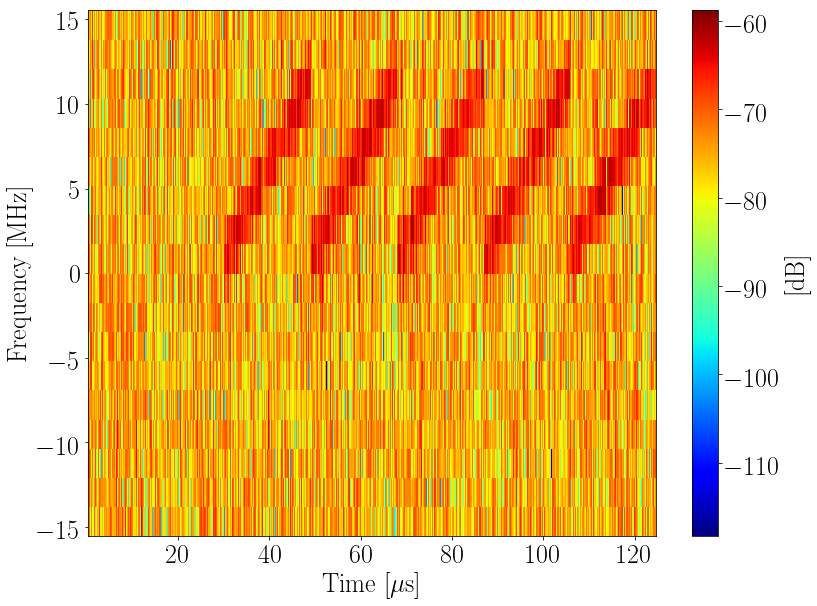

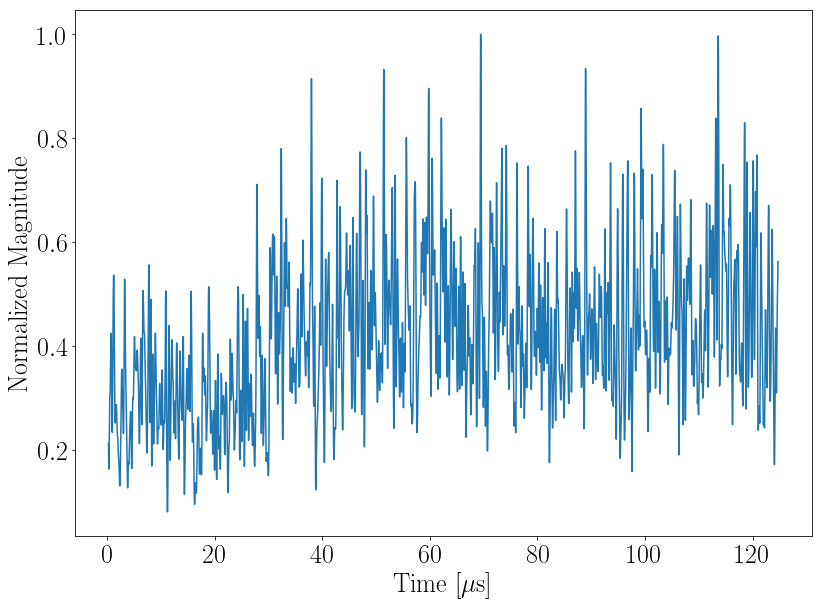

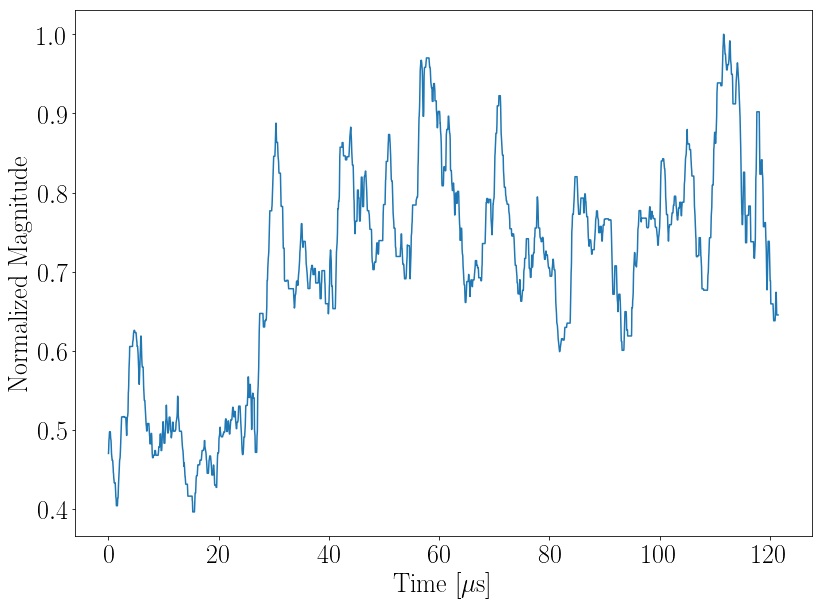

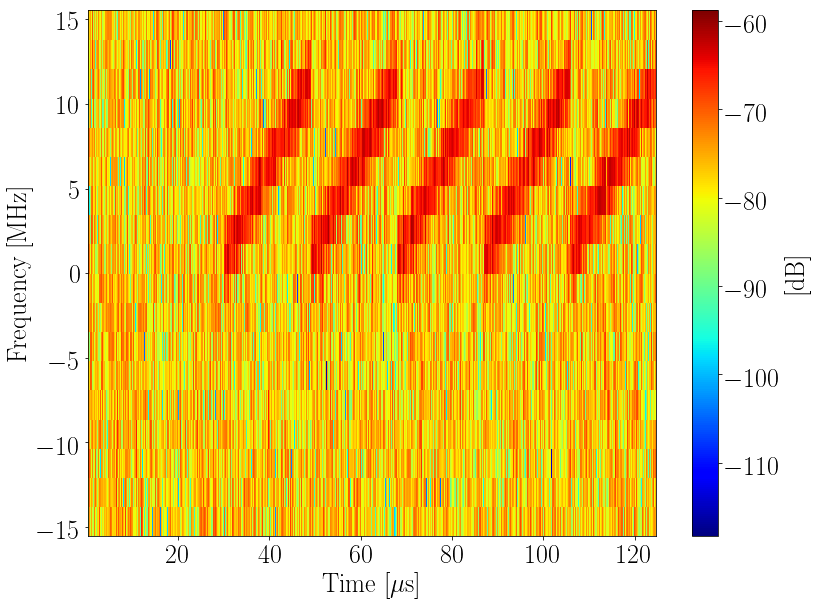

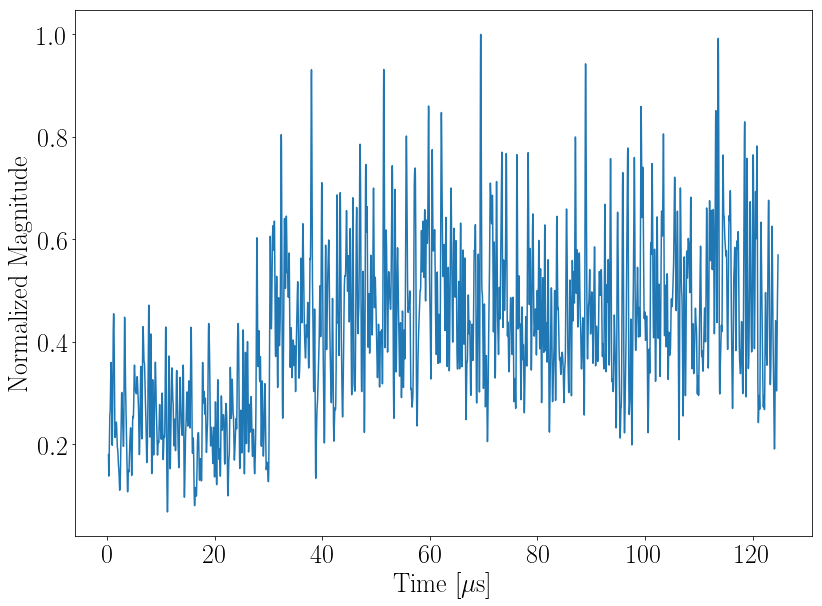

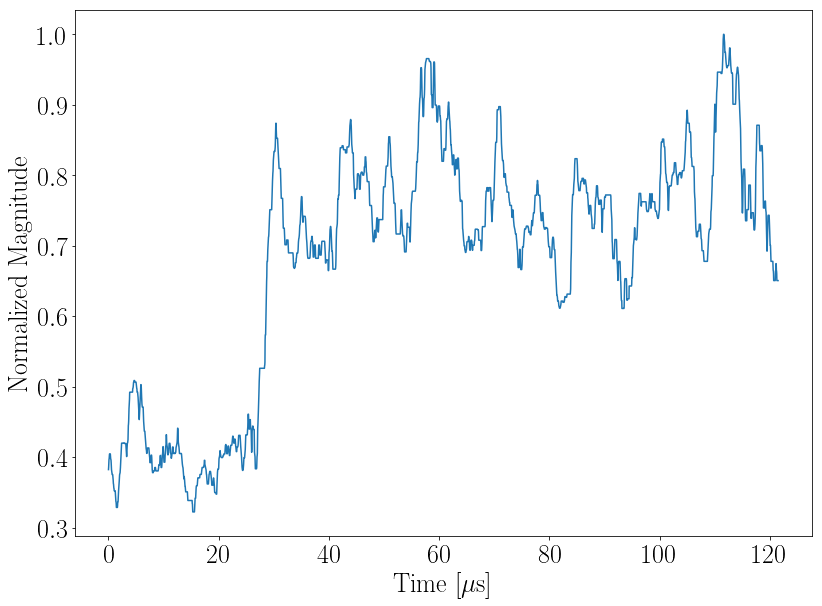

In [26]:
f0 = 0
stepPeriod = 1.48
totalSamples = 4096

secondsOfData = np.arange(8.62, 18.97+stepPeriod, stepPeriod)*1e-6
bandwidth = 10.72e6
JNRVector = [-4, -2, 0]

JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

for k in list(secondsOfData):
    
    numberOfSamples = int(k*fs)

    t = np.arange(0, k - 1/fs, 1/fs)    
    f = ((bandwidth/2)/k)*t + f0

    signal1 = np.exp(1j*2*np.pi*f*t)    
    signal1 = np.tile(signal1, np.floor(100e-6*fs).astype(int)//numberOfSamples)
    pow1 = pow_eval(signal1)
    signal1 = np.concatenate((np.zeros(totalSamples - signal1.shape[0]), signal1))

    noise = np.random.randn(len(signal1)) + 1j*np.random.randn(len(signal1))
    powNoise = pow_eval(noise)

    window_length = int(3e-6*fs)

    for j, i in enumerate(JNR):
        powAux = pow1/i
        noise2 = noise*np.sqrt(powAux/powNoise)
        data = signal1+noise2
        
        cmap = plt.get_cmap('jet')
        Pxx, freqs, bins, _ = plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=nfft-1, cmap=cmap,
                                          detrend='none', sides='twosided')
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inputNMF = np.abs(Pxx)
        inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)
        specdB = 10*np.log10(inputNMF)
        
        if j == 0:
            vmin = np.min(specdB)
            vmax = np.max(specdB)
            
        v = ax.pcolormesh(bins*1e6, freqs/1e6, specdB, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_ylabel('Frequency [MHz]')
        ax.set_xlabel('Time [$\mu$s]')
        fig.colorbar(v).ax.set_ylabel('[dB]')
        plt.tight_layout()
        saveFig(fig, figPath, ''.join(['spec_input_period', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                           str(int(k*1e6))]), save_fig=save_fig)
        plt.show()

        model = NMF(init='nndsvda', max_iter=10000, verbose=0, random_state=1, tol=1e-16, 
                      beta_loss=beta_loss, n_components=1, solver='mu')
        W = model.fit_transform(inputNMF)
        H = model.components_

        for l in range(H.shape[0]):
            HNorm = H[l,:]/np.max(H[l,:])
            H2 = median_window(HNorm, window_length)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(bins*1e6, HNorm)
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_period', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                            str(int(k*1e6))]), save_fig=save_fig)
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            taux = np.linspace(0, H2.shape[0]/fs, H2.shape[0])*1e6
            ax.plot(taux, H2/np.max(H2))
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_period', exp_name, 'JNR_', str(JNRVector[j]),'_',
                                             str(int(k*1e6)),'_window']), save_fig=save_fig)
            plt.show()
            

In [21]:
len(np.arange(8.62, 18.97+stepPeriod, stepPeriod)*1e-6)

8

# Saving log file

In [12]:
import json

In [13]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)